# <div style="text-align: right"> Chapter __18__</div>

# __Model basics with modelr__

## Introduction
The goal of a model is to provide a simple low-dimensional sum‐
mary of a dataset. In the context of this book we’re going to use
models to partition data into patterns and residuals. Strong patterns
will hide subtler trends, so we’ll use models to help peel back layers
of structure as we explore a dataset.

There are two parts to a model:

1. First, you define a family of models that express a precise, but
generic, pattern that you want to capture. For example, the pat‐
tern might be a straight line, or a quadatric curve. You will
express the model family as an equation like `y = a_1 * x + a_2` or
`y = a_1 * x ^ a_2` . Here, `x` and `y` are known variables
from your data, and `a_1` and `a_2` are parameters that can vary to
capture different patterns.

2. Next, you generate a fitted model by finding the model from the
family that is the closest to your data. This takes the generic
model family and makes it specific, like `y = 3 * x + 7` or
`y = 9 * x ^ 2 `.

It’s important to understand that a fitted model is just the closest
model from a family of models. That implies that you have the
“best” model (according to some criteria); it doesn’t imply that you
have a good model and it certainly doesn’t imply that the model is
“true.” George Box puts this well in his famous aphorism:

`All models are wrong, but some are useful.`

It’s worth reading the fuller context of the quote:
Now it would be very remarkable if any system existing in the real
world could be exactly represented by any simple model. However,
cunningly chosen parsimonious models often do provide remarka‐
bly useful approximations. For example, the law PV = RT relating
pressure P, volume V and temperature T of an “ideal” gas via a con‐
stant R is not exactly true for any real gas, but it frequently provides
a useful approximation and furthermore its structure is informative
since it springs from a physical view of the behavior of gas mole‐
cules.
For such a model there is no need to ask the question “Is the model
true?” If “truth” is to be the “whole truth” the answer must be “No.”
The only question of interest is “Is the model illuminating and use‐
ful?""

`The goal of a model is not to uncover truth, but to discover a simple
approximation that is still useful.`

In [1]:
# config
repr_html.tbl_df <- function(obj, ..., rows = 6) repr:::repr_html.data.frame(obj, ..., rows = rows)
options(dplyr.summarise.inform = FALSE)

In [2]:
library(tidyverse)
library(modelr)
options(na.action = na.warn)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.1
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



### A simple model
Let’s take a look at the simulated dataset `sim1` . It contains two continuous variables,` x` and `y` . Let’s plot them to see how they’re related:

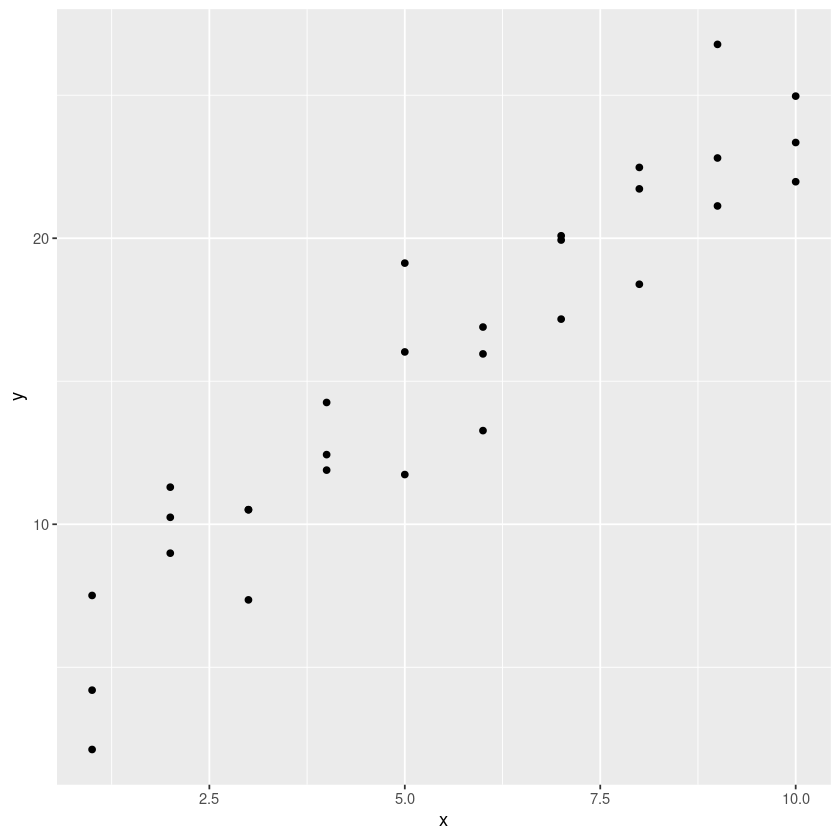

In [3]:
ggplot(sim1, aes(x, y)) +
    geom_point()

You can see a strong pattern in the data. Let’s use a model to capture
that pattern and make it explicit. It’s our job to supply the basic form
of the model. In this case, the relationship looks linear, i.e.,
`y = a_0 + a_1 * x` . Let’s start by getting a feel for what models from that
family look like by randomly generating a few and overlaying them
on the data. For this simple case, we can use `geom_abline()` , which
takes a slope and intercept as parameters. Later on we’ll learn more
general techniques that work with any model:

In [4]:
models <- tibble(
    a1 = runif(250, -20, 40),
    a2 = runif(250, -5, 5)
)

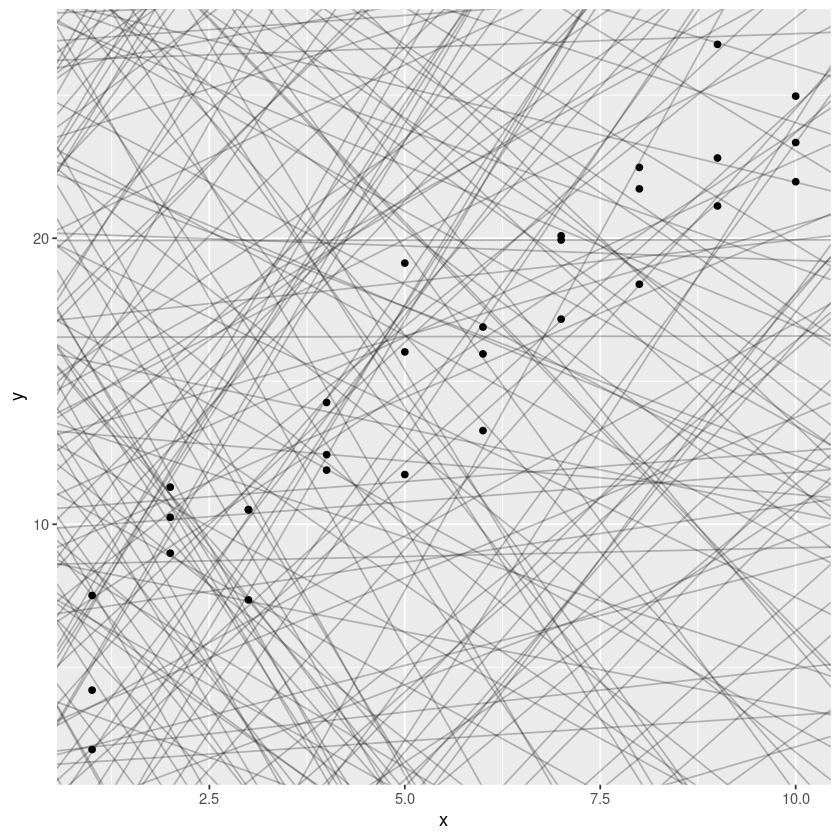

In [5]:
ggplot(sim1, aes(x, y)) +
    geom_abline(aes(intercept = a1, slope = a2),
                data = models, alpha = 1/4) +
    geom_point()

There are 250 models on this plot, but a lot are really bad! We need
to find the good models by making precise our intuition that a good
model is “close” to the data. We need a way to quantify the distance
between the data and a model. Then we can fit the model by finding
the values of `a_0` and `a_1` that generate the model with the smallest
distance from this data.
One easy place to start is to find the vertical distance between each
point and the model.
This distance is just the difference between the y value given by the
model (the prediction), and the actual y value in the data (the
response).
To compute this distance, we first turn our model family into an R
function. This takes the model parameters and the data as inputs,
and gives values predicted by the model as output

In [6]:
model1 <- function(a, data) {
    a[1] + data$x * a[2]
}
model1(c(7, 1.5), sim1)

[1]  8.5  8.5  8.5 10.0 10.0 10.0 11.5 11.5 11.5 13.0 13.0 13.0 14.5 14.5 14.5
[16] 16.0 16.0 16.0 17.5 17.5 17.5 19.0 19.0 19.0 20.5 20.5 20.5 22.0 22.0 22.0

Next, we need some way to compute an overall distance between the
predicted and actual values. In other words, the plot shows 30 distances: how do we collapse that into a single number?

One common way to do this in statistics is to use the “root-mean squared deviation.” We compute the difference between actual and
predicted, square them, average them, and then take the square root.

In [7]:
measure_distance <- function(mod, data) {
    diff <- data$y - model1(mod, data)
    sqrt(mean(diff ^ 2))
}

In [8]:
measure_distance(c(7, 1.5), sim1)

[1] 2.665212

Now we can use __purrr__ to compute the distance for all the models
defined previously. We need a helper function because our distance
function expects the model as a numeric vector of length 2:

In [9]:
sim1_dist <- function(a1, a2) {
    measure_distance(c(a1, a2), sim1)
}

In [10]:
models <- models %>%
    mutate(dist = map2_dbl(a1, a2, sim1_dist))

In [11]:
models

a1,a2,dist
<dbl>,<dbl>,<dbl>
27.650742,3.481239,31.63326
-14.950174,-2.044329,43.37828
-8.130187,-3.391037,45.13248
⋮,⋮,⋮
26.91999,3.5114970,31.08671
36.24266,-0.6160849,19.08555
15.28881,-4.6342862,32.15590


Next, let’s overlay the 10 best models on to the data. I’ve colored the
models by `-dist` : this is an easy way to make sure that the best models (i.e., the ones with the smallest distance) get the brighest colors:

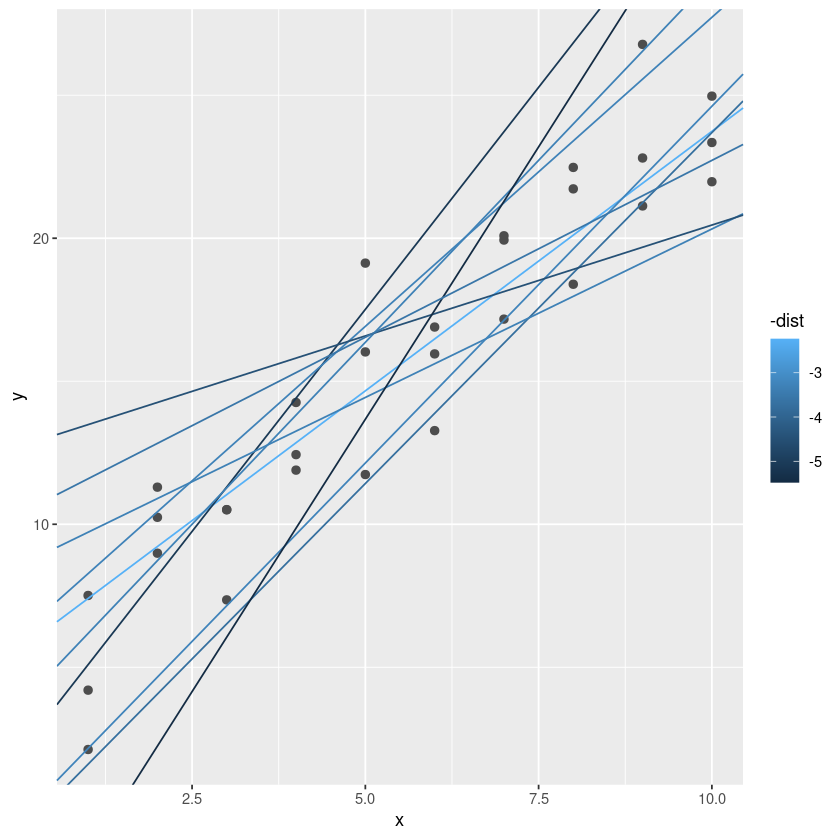

In [12]:
ggplot(sim1, aes(x, y)) +
    geom_point(size = 2, color = 'grey30') +
    geom_abline(aes(intercept = a1, slope = a2, color = -dist),
                data = filter(models, rank(dist) <= 10))

We can also think about these models as observations, and visualize
them with a scatterplot of `a1` versus `2` , again colored by -dist . We
can no longer directly see how the model compares to the data, but
we can see many models at once. Again, I’ve highlighted the 10 best
models, this time by drawing red circles underneath them:

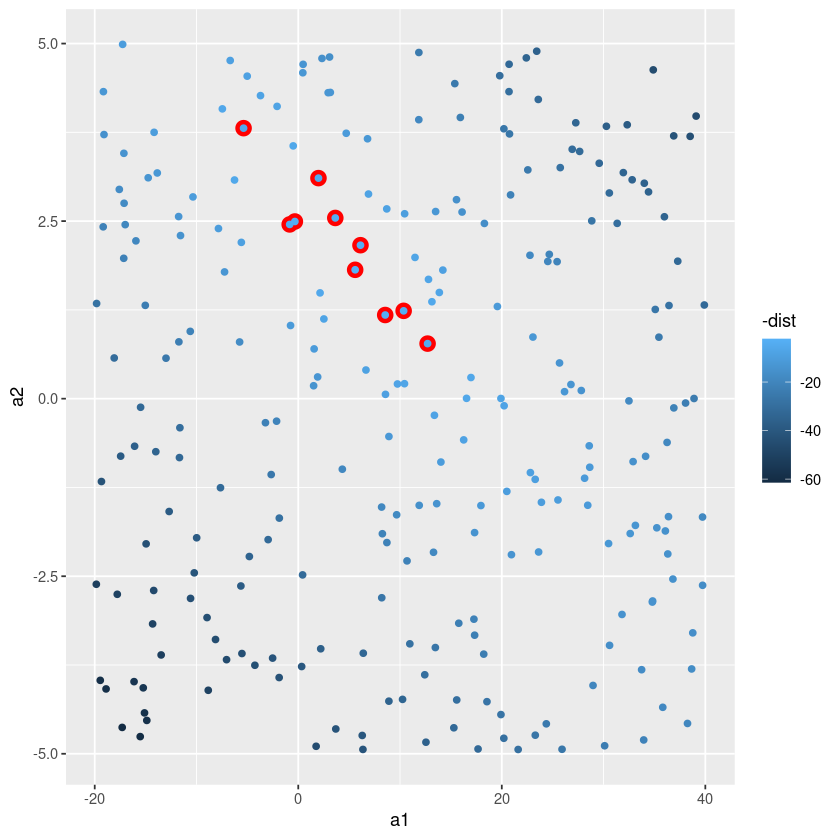

In [13]:
ggplot(models, aes(a1, a2)) +
    geom_point(data = filter(models, rank(dist) <= 10),
               size = 4,
               color = 'red') +
    geom_point(aes(color = -dist))

Instead of trying lots of random models, we could be more system‐
atic and generate an evenly spaced grid of points (this is called a grid
search). I picked the parameters of the grid roughly by looking at
where the best models were in the preceding plot:

In [14]:
grid <- expand.grid(
    a1 = seq(-5, 20, length = 25),
    a2 = seq(1, 3, length = 25)
) %>%
    mutate(dist = map2_dbl(a1, a2, sim1_dist))

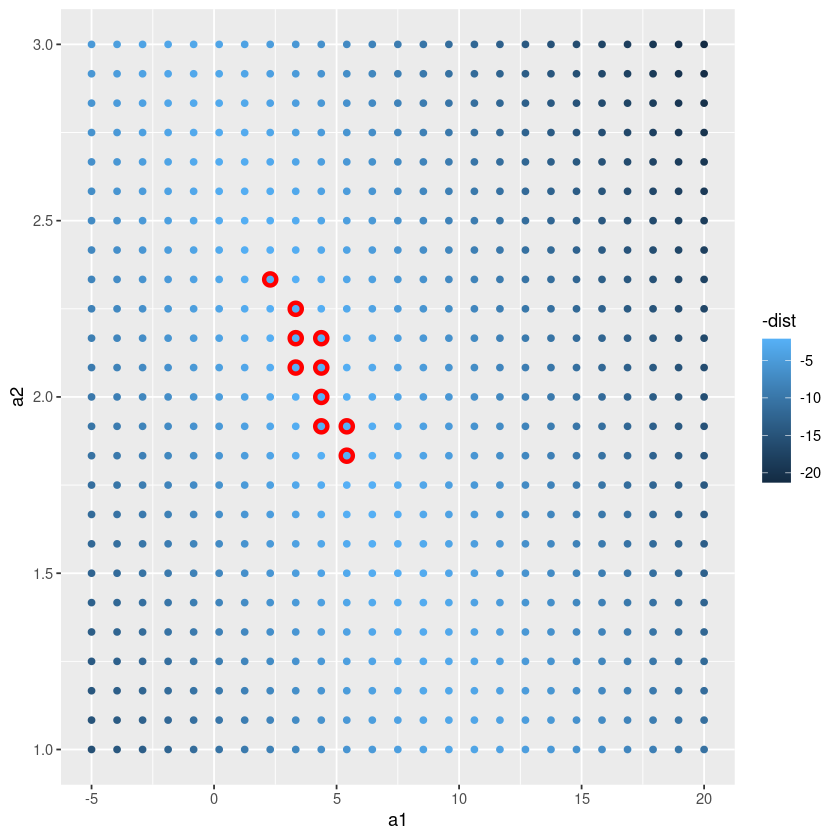

In [15]:
grid %>%
    ggplot(aes(a1, a2)) +
    geom_point(data = filter(grid, rank(dist) <= 10),
               size = 4,
               color = 'red') +
    geom_point(aes(color = -dist))

When you overlay the best 10 models back on the original data, they
all look pretty good:

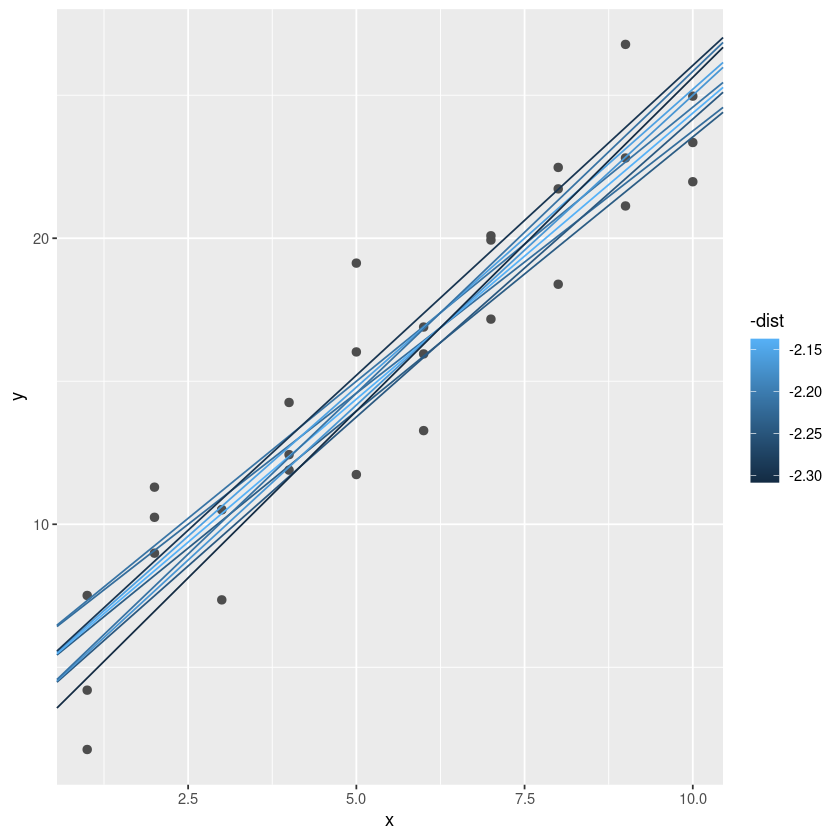

In [16]:
ggplot(sim1, aes(x, y)) +
    geom_point(size = 2,
               color = 'grey30') +
    geom_abline(aes(intercept = a1,
                    slope = a2,
                    color = -dist),
                data = filter(grid, rank(dist) <= 10))

You could imagine iteratively making the grid finer and finer until
you narrowed in on the best model. But there’s a better way to tackle
that problem: a numerical minimization tool called Newton–Raph‐
son search. The intuition of Newton–Raphson is pretty simple: you
pick a starting point and look around for the steepest slope. You
then ski down that slope a little way, and then repeat again and
again, until you can’t go any lower. In R, we can do that with
`optim()` :

In [17]:
best <- optim(c(0, 0), measure_distance, data = sim1)
best$par

[1] 4.222248 2.051204

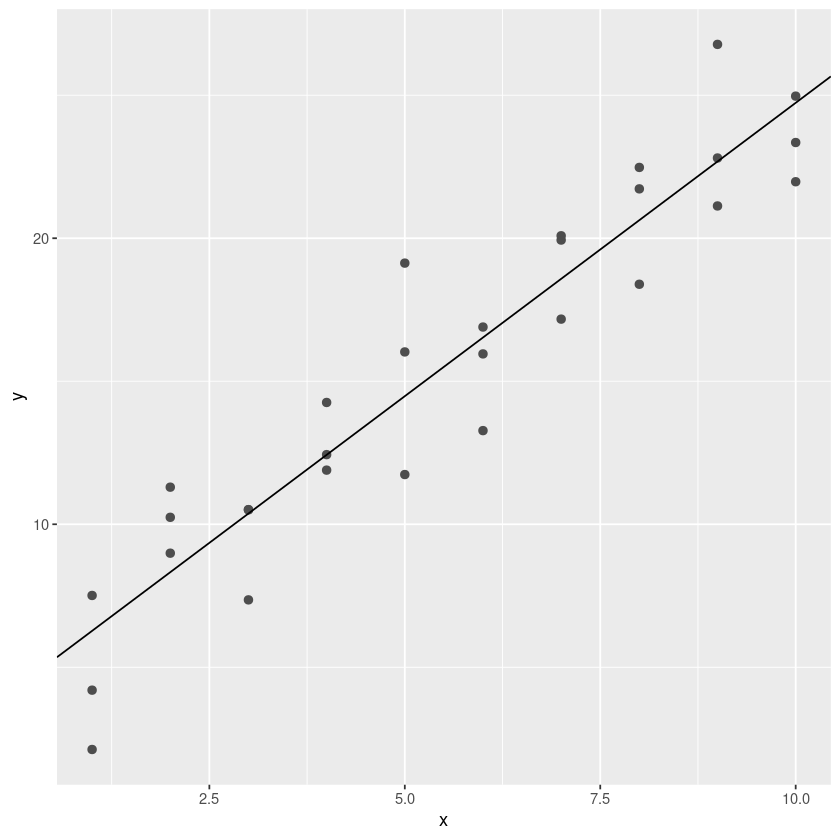

In [18]:
ggplot(sim1, aes(x, y)) +
    geom_point(size = 2,
               color = 'grey30') +
    geom_abline(intercept = best$par[1],
                slope = best$par[2])

Don’t worry too much about the details of how `optim()` works. It’s
the intuition that’s important here. If you have a function that
defines the distance between a model and a dataset, and an algorithm that can minimize that distance by modifying the parameters
of the model, you can find the best model. The neat thing about this
approach is that it will work for any family of models that you can
write an equation for.

There’s one more approach that we can use for this model, because it
is a special case of a broader family: linear models. A linear model
has the general form
`y = a_1 + a_2 * x_1 + a_3 * x_2 + ... + a_n * x_(n - 1)` .
So this simple model is equivalent to a general
linear model where `n` is `2` and `x_1` i `x` . R has a tool specifically
designed for fitting linear models called `lm()` . `lm()` has a special way
to specify the model family: formulas. Formulas look like `y ~ x` ,
which `lm()` will translate to a function like `y = a_1 + a_2 * x` . We
can fit the model and look at the output:

In [19]:
sim1_mod <- lm(y ~ x, data = sim1)
coef(sim1_mod)

(Intercept)           x 
   4.220822    2.051533

These are exactly the same values we got with `optim()` ! Behind the
scenes `lm()` doesn’t use `optim()` but instead takes advantage of the
mathematical structure of linear models. Using some connections
between geometry, calculus, and linear algebra, `lm()` actually finds
the closest model in a single step, using a sophisticated algorithm.
This approach is faster and guarantees that there is a global minimum.

### __Excercises__

1. __One downside of the linear model is that it is sensitive to
unusual values because the distance incorporates a squared
term. Fit a linear model to the following simulated data, and vis‐
ualize the results. Rerun a few times to generate different simu‐
lated datasets. What do you notice about the model?__measure_distance <- function(mod, data) {
  diff <- data$y - make_prediction(mod, data)
  mean(abs(diff))
}

In [20]:
sim1a <- tibble(
  x = rep(1:10, each = 3),
  y = x * 1.5 + 6 + rt(length(x), df = 2)
)

Lets run it once and plot the results

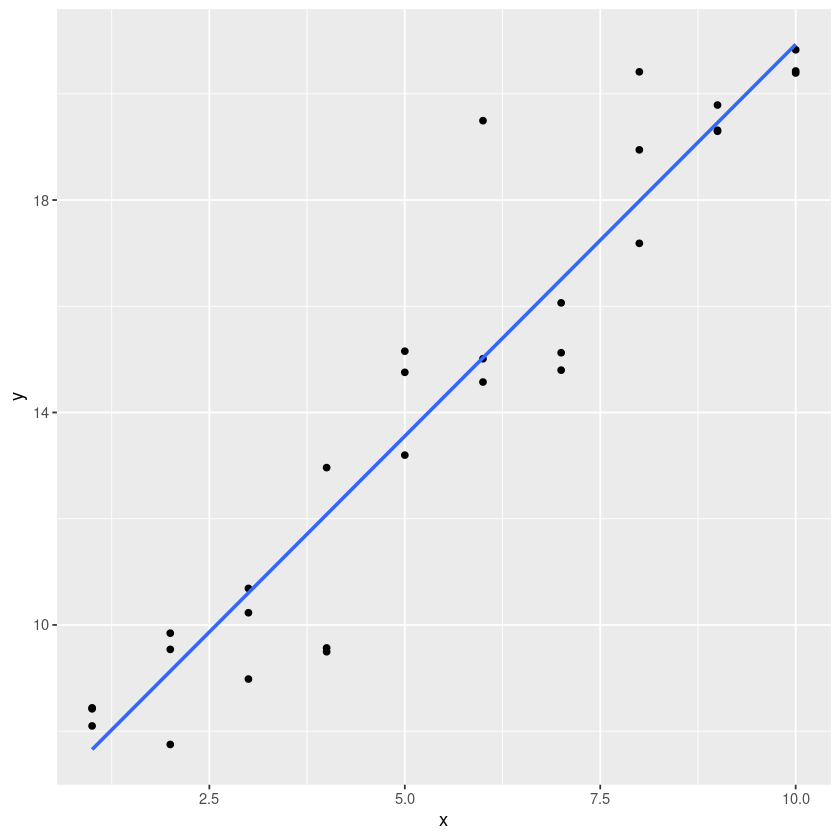

In [21]:
ggplot(sim1a, aes(x = x, y = y)) +
  geom_point() +
  geom_smooth(method = "lm",
              se = FALSE,
              formula = y ~ x)

 We can also do this more systematically, by generating several simulations and plotting the line.

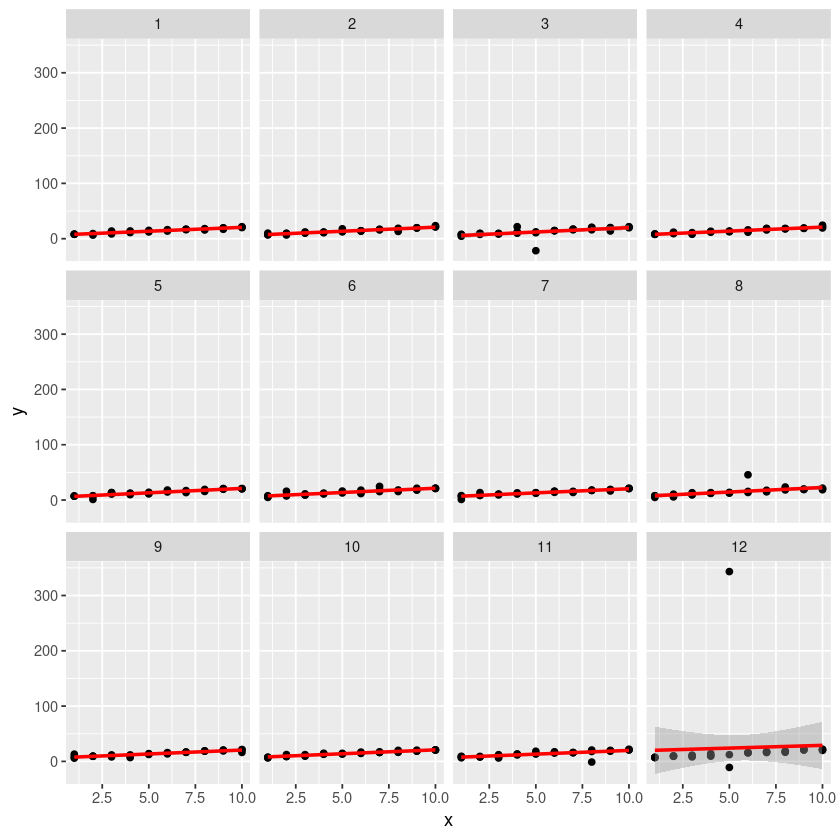

In [22]:
simt <- function(i) {
  tibble(
    x = rep(1:10, each = 3),
    y = x * 1.5 + 6 + rt(length(x), df = 2),
    .id = i
  )
}

sims <- map_df(1:12, simt)

ggplot(sims, aes(x = x, y = y)) +
  geom_point() +
  geom_smooth(method = "lm",
              colour = "red",
              formula = y ~ x) +
  facet_wrap(~.id, ncol = 4)

What if we did the same things with normal distributions?

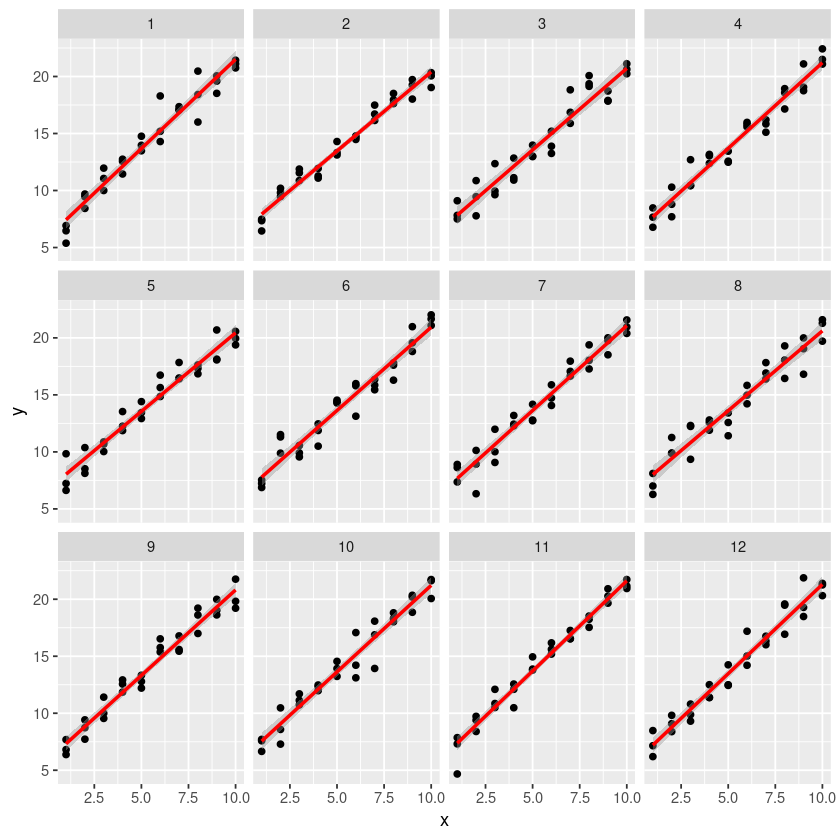

In [23]:
sim_norm <- function(i) {
  tibble(
    x = rep(1:10, each = 3),
    y = x * 1.5 + 6 + rnorm(length(x)),
    .id = i
  )
}

simdf_norm <- map_df(1:12, sim_norm)

ggplot(simdf_norm, aes(x = x, y = y)) +
  geom_point() +
  geom_smooth(method = "lm", colour = "red",
              formula = y ~ x) +
  facet_wrap(~.id, ncol = 4)

There are not large outliers, and the slopes are more similar.

The reason for this is that the Student’s t
-distribution, from which we sample with `rt()` has heavier tails than the normal distribution (`rnorm()`). This means that the Student’s t-distribution assigns a larger probability to values further from the center of the distribution.

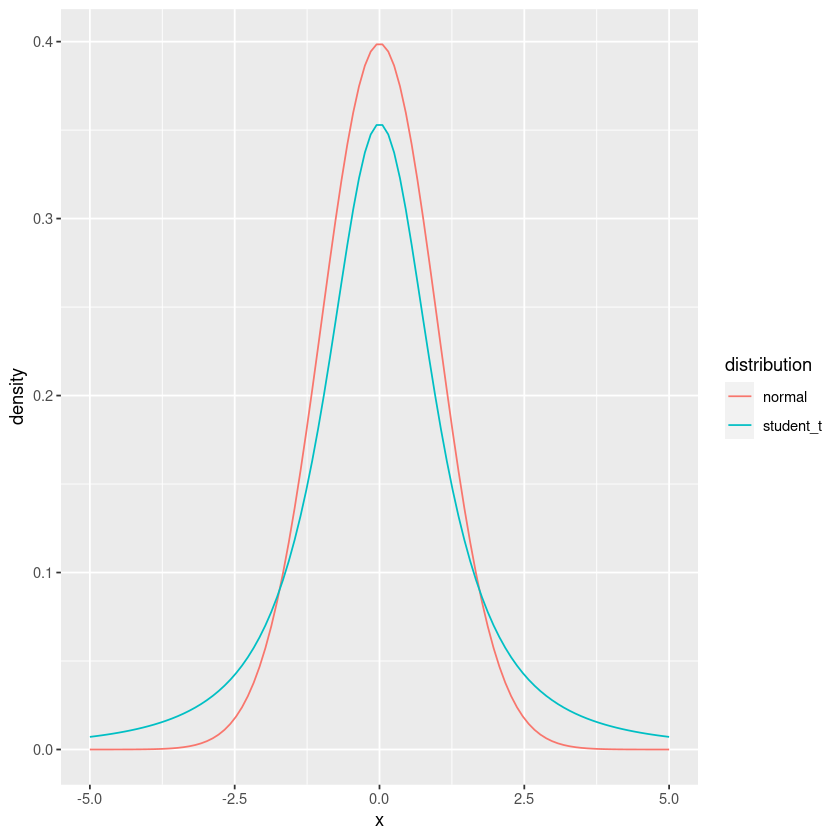

In [24]:
tibble(
  x = seq(-5, 5, length.out = 100),
  normal = dnorm(x),
  student_t = dt(x, df = 2)
) %>%
  pivot_longer(-x, names_to="distribution", values_to="density") %>%
  ggplot(aes(x = x, y = density, colour = distribution)) +
  geom_line()

For a normal distribution with mean zero and standard deviation one, the probability of being greater than 2 is,

In [25]:
pnorm(2, lower.tail = FALSE)

[1] 0.02275013

For a Student’s t distribution with degrees of freedom = 2, it is more than 3 times higher,

In [26]:
pt(2, df = 2, lower.tail = FALSE)

[1] 0.09175171

2. __One way to make linear models more robust is to use a different
distance measure. For example, instead of root-mean-squared
distance, you could use mean-absolute distance:__

In [27]:
measure_distance <- function(mod, data) {
  diff <- data$y - make_prediction(mod, data)
  mean(abs(diff))
}

For the above function to work, we need to define a function, `make_prediction()`, that takes a numeric vector of length two (the intercept and slope) and returns the predictions,

In [28]:
make_prediction <- function(mod, data) {
  mod[1] + mod[2] * data$x
}

Using the `sim1a` data, the best parameters of the least absolute deviation are:

In [29]:
best <- optim(c(0, 0), measure_distance, data = sim1a)
best$par

[1] 6.715720 1.382636

Using the `sim1a` data, while the parameters the minimize the least squares objective function are:

In [30]:
measure_distance_ls <- function(mod, data) {
  diff <- data$y - (mod[1] + mod[2] * data$x)
  sqrt(mean(diff^2))
}

best <- optim(c(0, 0), measure_distance_ls, data = sim1a)
best$par

[1] 6.180036 1.474897

3. __One challenge with performing numerical optimization is that
it’s only guaranteed to find one local optima. What’s the problem with optimizing a three-parameter model like this?__

In [31]:
model3 <- function(a, data) {
    a[1] + data$x * a[2] + a[3]
}

The problem is that you for any values `a[1] = a1` and `a[3] = a3`, any other values of `a[1]` and `a[3]` where `a[1] + a[3] == (a1 + a3)` will have the same fit.

In [32]:
measure_distance_3 <- function(a, data) {
  diff <- data$y - model3(a, data)
  sqrt(mean(diff^2))
}

Depending on our starting points, we can find different optimal values:

In [33]:
best3a <- optim(c(0, 0, 0), measure_distance_3, data = sim1)
best3a$par

[1] 3.3672228 2.0515737 0.8528513

In [34]:
best3b <- optim(c(0, 0, 1), measure_distance_3, data = sim1)
best3b$par

[1] -3.469885  2.051509  7.690289

In [35]:
best3c <- optim(c(0, 0, 5), measure_distance_3, data = sim1)
best3c$par

[1] -1.124446  2.051520  5.345616

## __Visualizing Models__

For simple models, like the one in the previous section, you can fig‐
ure out what pattern the model captures by carefully studying the
model family and the fitted coefficients. And if you ever take a sta‐
tistics course on modeling, you’re likely to spend a lot of time doing
just that. Here, however, we’re going to take a different tack. We’re
going to focus on understanding a model by looking at its predic‐
tions. This has a big advantage: every type of predictive model
makes predictions (otherwise what use would it be?) so we can use
the same set of techniques to understand any type of predictive
model.

It’s also useful to see what the model doesn’t capture, the so-called
residuals that are left after subtracting the predictions from the data.
Residuals are powerful because they allow us to use models to
remove striking patterns so we can study the subtler trends that
remain.

### Predictions

To visualize the predictions from a model, we start by generating an
evenly spaced grid of values that covers the region where our data
lies. The easiest way to do that is to use `modelr::data_grid()` . Its
first argument is a data frame, and for each subsequent argument it
finds the unique variables and then generates all combinations:

In [36]:
grid <- sim1 %>%
    data_grid(x)

In [37]:
grid

x
<int>
1
2
3
⋮
8
9
10


(This will get more interesting when we start to add more variables
to our model.)
Next we add predictions. We’ll use `modelr::add_predictions()` ,
which takes a data frame and a model. It adds the predictions from
the model to a new column in the data frame:

In [38]:
grid <- grid %>%
    add_predictions(sim1_mod)

In [39]:
grid

x,pred
<int>,<dbl>
1,6.272355
2,8.323888
3,10.375421
⋮,⋮
8,20.63309
9,22.68462
10,24.73615


Next, we plot the predictions. You might wonder about all this extra
work compared to just using `geom_abline() `. But the advantage of
this approach is that it will work with any model in R, from the sim‐
plest to the most complex. You’re only limited by your visualization
skills.

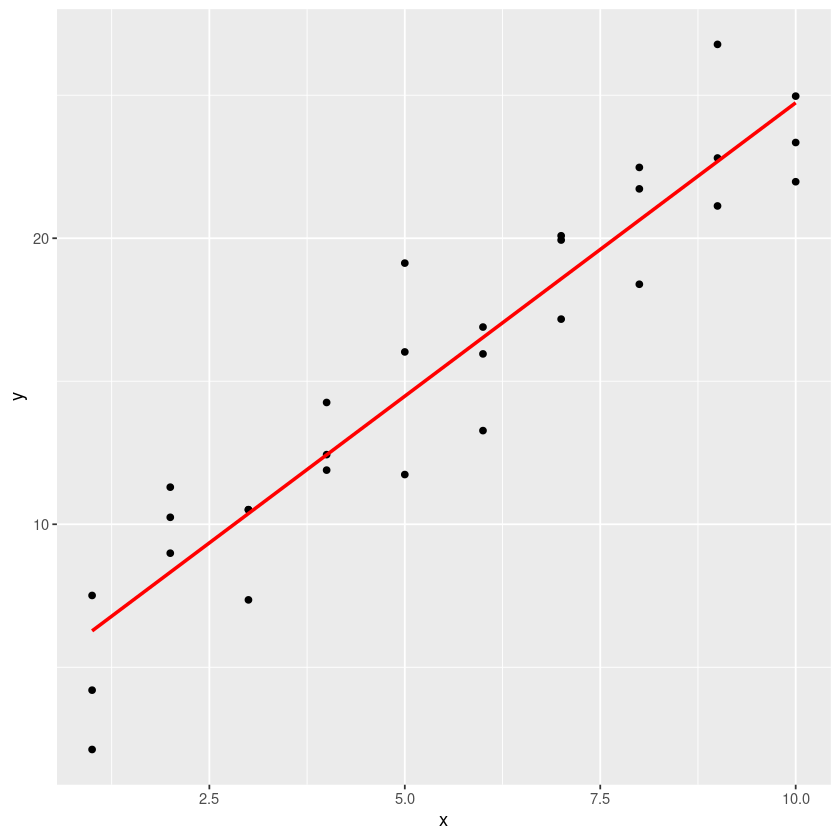

In [40]:
ggplot(sim1, aes(x)) +
    geom_point(aes(y = y)) +
    geom_line(aes(y = pred),
              data = grid,
              color = 'red',
              size = 1)

### Residuals

The flip side of predictions are residuals. The predictions tell you the
pattern that the model has captured, and the residuals tell you what
the model has missed. The residuals are just the distances between
the observed and predicted values that we computed earlier.

We add residuals to the data with `add_residuals()` , which works
much like `add_predictions()` . Note, however, that we use the original dataset, not a manufactured grid. This is because to compute
residuals we need actual y values:

In [41]:
sim1 <- sim1 %>%
    add_residuals(sim1_mod)

In [42]:
sim1

x,y,resid
<int>,<dbl>,<dbl>
1,4.199913,-2.072442
1,7.510634,1.238279
1,2.125473,-4.146882
⋮,⋮,⋮
10,24.96810,0.2319467
10,23.34642,-1.3897306
10,21.97520,-2.7609520


There are a few different ways to understand what the residuals tell
us about the model. One way is to simply draw a frequency polygon
to help us understand the spread of the residuals:

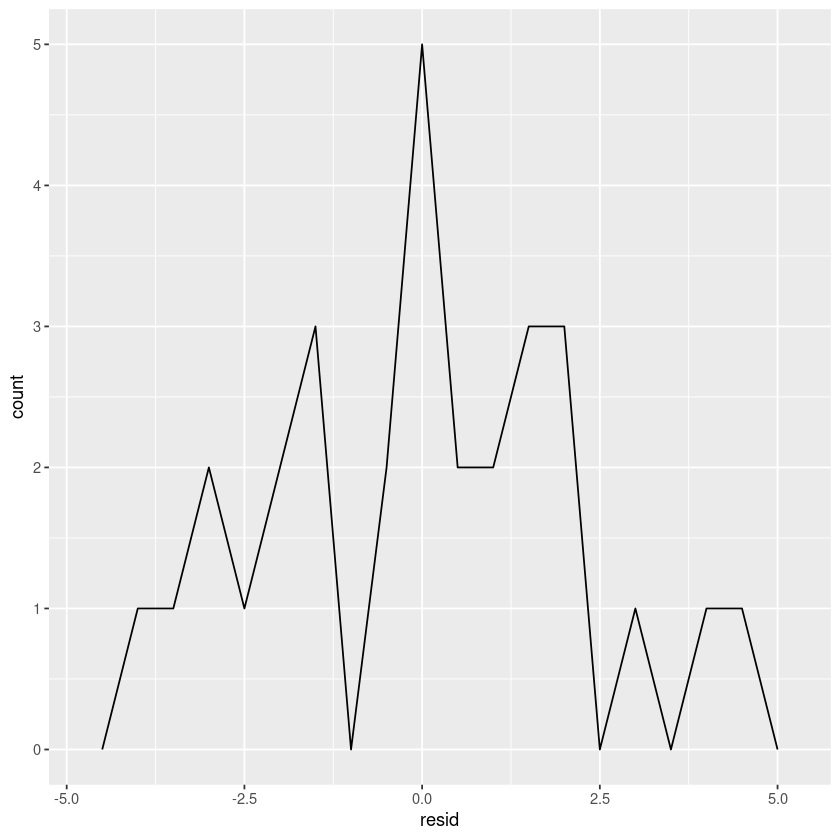

In [43]:
ggplot(sim1, aes(resid)) +
    geom_freqpoly(binwidth = 0.5)

This helps you calibrate the quality of the model: how far away are
the predictions from the observed values? Note that the average of
the residual will always be 0.

You’ll often want to re-create plots using the residuals instead of the
original predictor. You’ll see a lot of that in the next chapter:

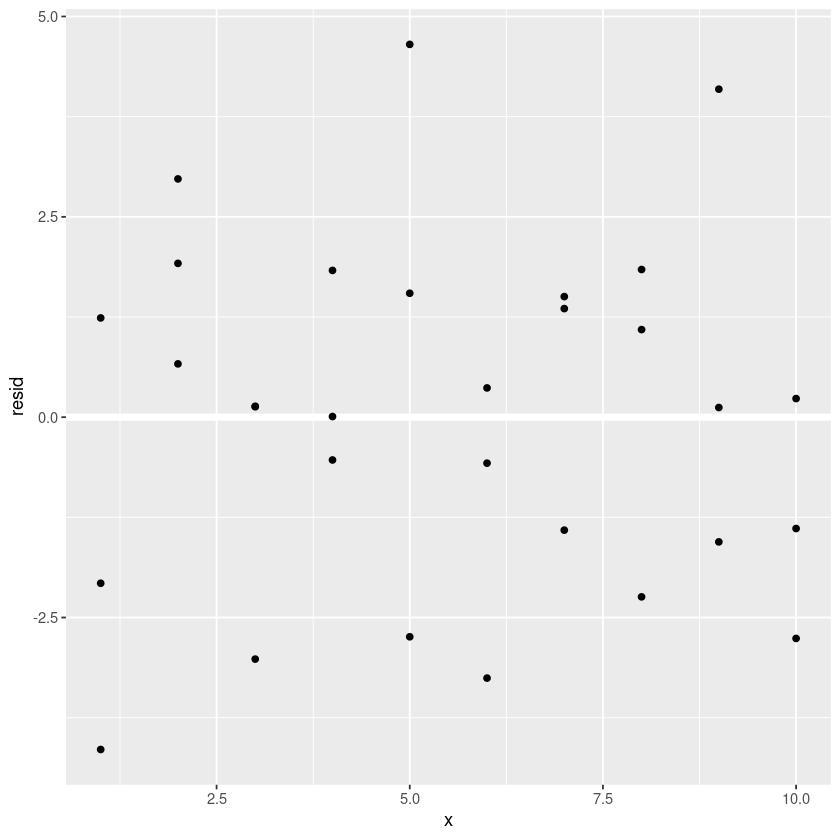

In [44]:
ggplot(sim1, aes(x, resid)) +
    geom_ref_line(h = 0) +
    geom_point()

This looks like random noise, suggesting that our model has done a
good job of capturing the patterns in the dataset.

### __Exercises__

1. __Instead of using `lm()` to fit a straight line, you can use `loess()`
to fit a smooth curve. Repeat the process of model fitting, grid
generation, predictions, and visualization on `sim1` using
`loess()` instead of `lm()` . How does the result compare to
`geom_smooth()` ?__

In [45]:
sim1_loess <- loess(y ~ x, data = sim1)
sim1_lm <- lm(y ~ x, data = sim1)

grid_loess <- sim1 %>%
  add_predictions(sim1_loess)

sim1 <- sim1 %>%
  add_residuals(sim1_lm) %>%
  add_predictions(sim1_lm) %>%
  add_residuals(sim1_loess, var = "resid_loess") %>%
  add_predictions(sim1_loess, var = "pred_loess")

This plots the `loess` predictions. The `loess` produces a nonlinear, smooth line through the data.

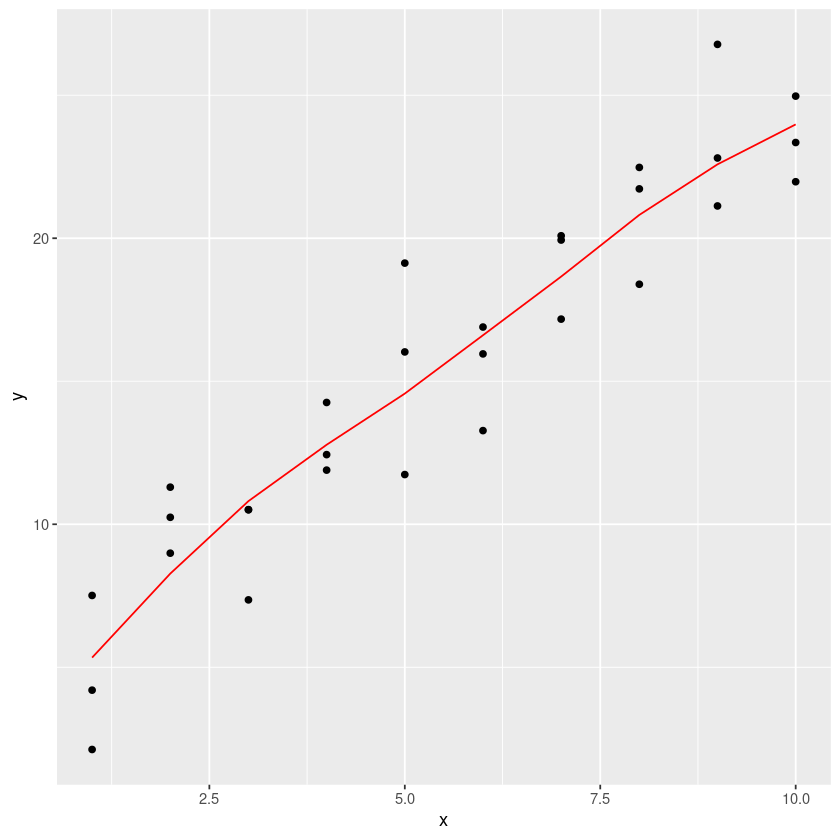

In [46]:
ggplot(sim1, aes(x = x, y = y)) +
  geom_point() +
  geom_line(aes(x = x, y = pred), data = grid_loess, colour = "red")

The predictions of loess are the same as the default method for `geom_smooth()` because `geom_smooth()` uses `loess()` by default; the message even tells us that.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



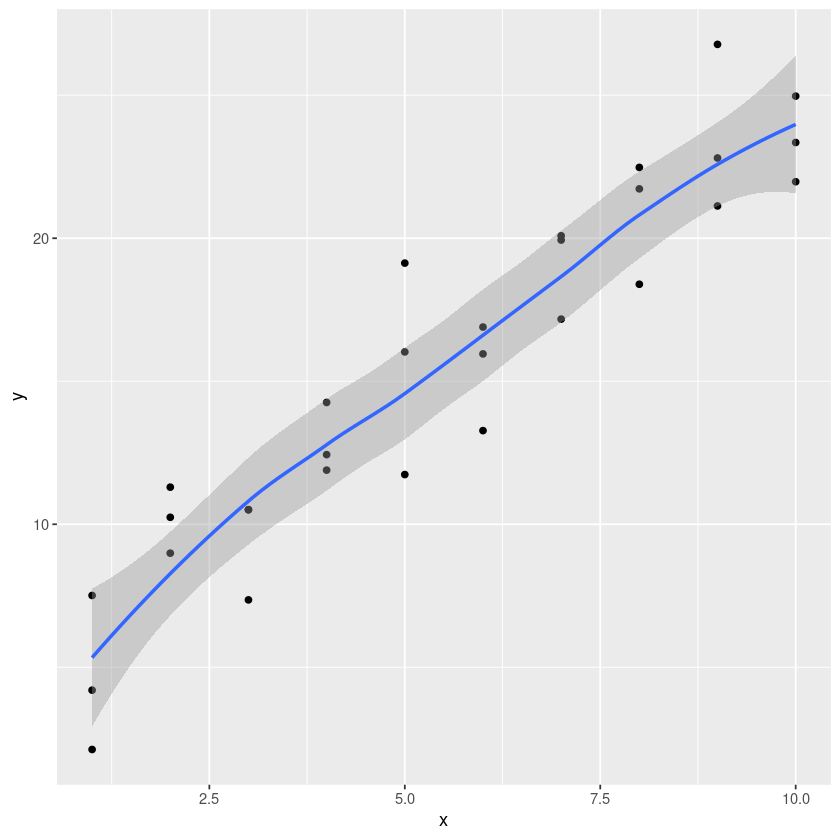

In [47]:
ggplot(sim1, aes(x = x, y = y)) +
    geom_point() +
    geom_smooth()

2. __`add_predictions()` is paired with gather_predictions() and
`spread_predictions()` . How do these three functions differ?__

The functions `gather_predictions()` and `spread_predictions()` allow for adding predictions from multiple models at once.

Taking the `sim1_mod` example

In [48]:
sim1_mod <- lm(y ~ x, data = sim1)
grid <- sim1 %>%
    data_grid(x)

The function `add_predictions()` adds only a single model at a time. To add two models:

In [49]:
grid %>%
  add_predictions(sim1_mod, var = "pred_lm") %>%
  add_predictions(sim1_loess, var = "pred_loess")

x,pred_lm,pred_loess
<int>,<dbl>,<dbl>
1,6.272355,5.338000
2,8.323888,8.274913
3,10.375421,10.809582
⋮,⋮,⋮
8,20.63309,20.81576
9,22.68462,22.58343
10,24.73615,23.97961


The function `gather_predictions()` adds predictions from multiple models by stacking the results and adding a column with the model name,

In [50]:
grid %>%
    gather_predictions(sim1_mod, sim1_loess)

model,x,pred
<chr>,<int>,<dbl>
sim1_mod,1,6.272355
sim1_mod,2,8.323888
sim1_mod,3,10.375421
⋮,⋮,⋮
sim1_loess,8,20.81576
sim1_loess,9,22.58343
sim1_loess,10,23.97961


The function `spread_predictions)` adds predictions from multiple models by adding multiple columns (postfixed with the model name) with predictions from each model.

In [51]:
grid %>%
    spread_predictions(sim1_mod, sim1_loess)

x,sim1_mod,sim1_loess
<int>,<dbl>,<dbl>
1,6.272355,5.338000
2,8.323888,8.274913
3,10.375421,10.809582
⋮,⋮,⋮
8,20.63309,20.81576
9,22.68462,22.58343
10,24.73615,23.97961


The function `spread_predictions()` is similar to the example which runs `add_predictions()` for each model, and is equivalent to running `spread()` after running `gather_predictions()`:

In [52]:
grid %>%
    gather_predictions(sim1_mod, sim1_loess) %>%
    spread(model, pred)

x,sim1_loess,sim1_mod
<int>,<dbl>,<dbl>
1,5.338000,6.272355
2,8.274913,8.323888
3,10.809582,10.375421
⋮,⋮,⋮
8,20.81576,20.63309
9,22.58343,22.68462
10,23.97961,24.73615


3. __What does `geom_ref_line()` do? What package does it come
from? Why is displaying a reference line in plots showing resid‐
uals useful and important?__

The geom `geom_ref_line()` adds as reference line to a plot. It is equivalent to running `geom_hline()` or `geom_vline()` with default settings that are useful for visualizing models. Putting a reference line at zero for residuals is important because good models (generally) should have residuals centered at zero, with approximately the same variance (or distribution) over the support of x, and no correlation. A zero reference line makes it easier to judge these characteristics visually.

4. __Why might you want to look at a frequency polygon of absolute
residuals? What are the pros and cons compared to looking at
the raw residuals?__

Showing the absolute values of the residuals makes it easier to view the spread of the residuals. The model assumes that the residuals have mean zero, and using the absolute values of the residuals effectively doubles the number of residuals.

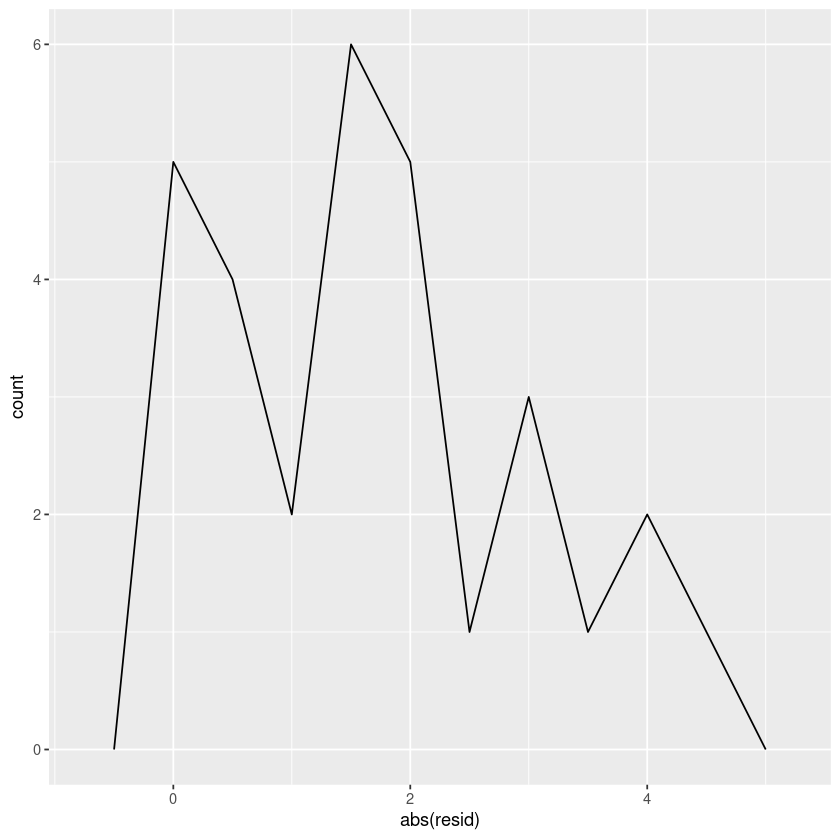

In [53]:
sim1_mod <- lm(y ~ x, data = sim1)

sim1 <- sim1 %>%
    add_residuals(sim1_mod)

ggplot(sim1, aes(x = abs(resid))) +
    geom_freqpoly(binwidth = 0.5)

However, using the absolute values of residuals throws away information about the sign, meaning that the frequency polygon cannot show whether the model systematically over- or under-estimates the residuals.

## __Formulas and Model Families__

You’ve seen formulas before when using `facet_wrap()` and
`facet_grid()` . In R, formulas provide a general way of getting “special behavior.” Rather than evaluating the values of the variables
right away, they capture them so they can be interpreted by the function.

The majority of modeling functions in R use a standard conversion
from formulas to functions. You’ve seen one simple conversion
already: `y ~ x` is translated to `y = a_1 + a_2 * x` . If you want to
see what R actually does, you can use the `model_matrix()` function.
It takes a data frame and a formula and returns a tibble that defines
the model equation: each column in the output is associated with
one coefficient in the model, and the function is always
`y = a_1 * out1 + a_2 * out_2` . For the simplest case of `y ~ x1` this shows us
something interesting:

In [54]:
df <- tribble(
    ~y, ~x1, ~x2,
    4, 2, 5,
    5, 1, 6
)

In [55]:
model_matrix(df, y ~ x1)

(Intercept),x1
<dbl>,<dbl>
1,2
1,1


The way that R adds the intercept to the model is just by having a
column that is full of ones. By default, R will always add this column. If you don’t want that, you need to explicitly drop it with -1 :

In [56]:
model_matrix(df, y ~ x1 - 1)

x1
<dbl>
2
1


The model matrix grows in an unsurprising way when you add
more variables to the model:

In [57]:
model_matrix(df, y ~ x1 + x2)

(Intercept),x1,x2
<dbl>,<dbl>,<dbl>
1,2,5
1,1,6


### Categorical Variables

Generating a function from a formula is straightforward when the
predictor is continuous, but things get a bit more complicated when
the predictor is categorical. Imagine you have a formula like
`y ~ sex `, where sex could either be male or female. It doesn’t make sense
to convert that to a formula like `y = x_0 + x_1 * sex ` because sex
isn’t a number—you can’t multiply it! Instead what R does is convert
it to `y = x_0 + x_1 * sex_male` where `sex_male` is one if `sex` is
male and zero otherwise:

In [58]:
df <- tribble(
    ~sex, ~response,
    'male', 1,
    'female', 2,
    'male', 1
)

In [59]:
model_matrix(df, response ~ sex)

(Intercept),sexmale
<dbl>,<dbl>
1,1
1,0
1,1


You might wonder why R also doesn’t create a sexfemale column.
The problem is that would create a column that is perfectly predictable based on the other columns (i.e., sexfemale = 1 - sexmale ).
Unfortunately the exact details of why this is a problem is beyond
the scope of this book, but basically it creates a model family that is
too flexible, and will have infinitely many models that are equally
close to the data.

Fortunately, however, if you focus on visualizing predictions you
don’t need to worry about the exact parameterization. Let’s look at
some data and models to make that concrete. Here’s the sim2 dataset
from modelr:

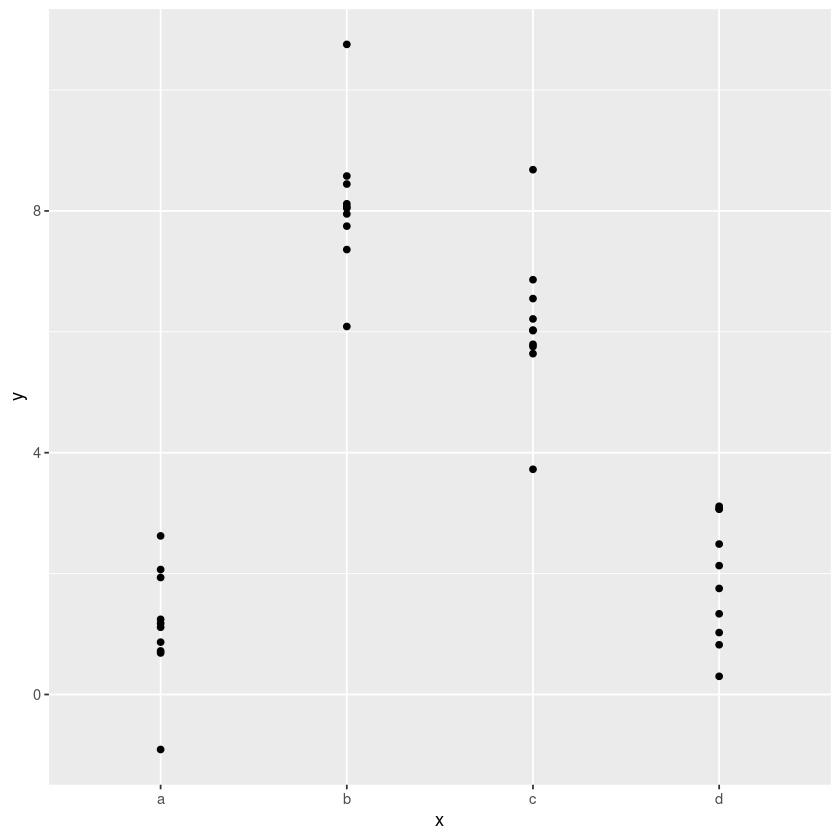

In [60]:
ggplot(sim2) +
    geom_point(aes(x, y))

We can fit a model to it, and generate predictions:

In [61]:
mod2 <- lm(y ~ x, data = sim2)

In [62]:
grid <- sim2 %>%
    data_grid(x) %>%
    add_predictions(mod2)

In [63]:
grid

x,pred
<chr>,<dbl>
a,1.152166
b,8.116039
c,6.127191
d,1.910981


Effectively, a model with a categorical x will predict the mean value
for each category. (Why? Because the mean minimizes the root-
mean-squared distance.) That’s easy to see if we overlay the predictions on top of the original data:

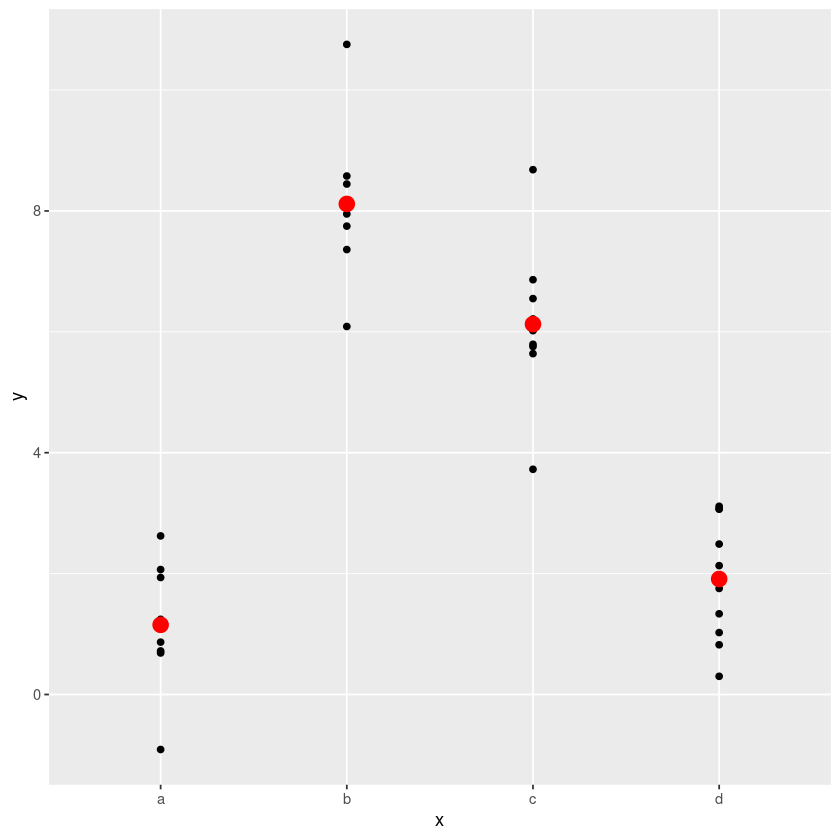

In [64]:
ggplot(sim2, aes(x)) +
    geom_point(mapping = aes(y = y)) +
    geom_point(data = grid,
               mapping = aes(y = pred),
               color = 'red',
               size = 4)

You can’t make predictions about levels that you didn’t observe.
Sometimes you’ll do this by accident so it’s good to recognize this
error message:

In [65]:
tibble(x = 'e') %>%
    add_predictions(mod2)

ERROR: Error in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$xlevels): factor x has new level e


### Interactions (Continuous and Categorical)

What happens when you combine a continuous and a categorical
variable? `sim3` contains a categorical predictor and a continuous
predictor. We can visualize it with a simple plot:

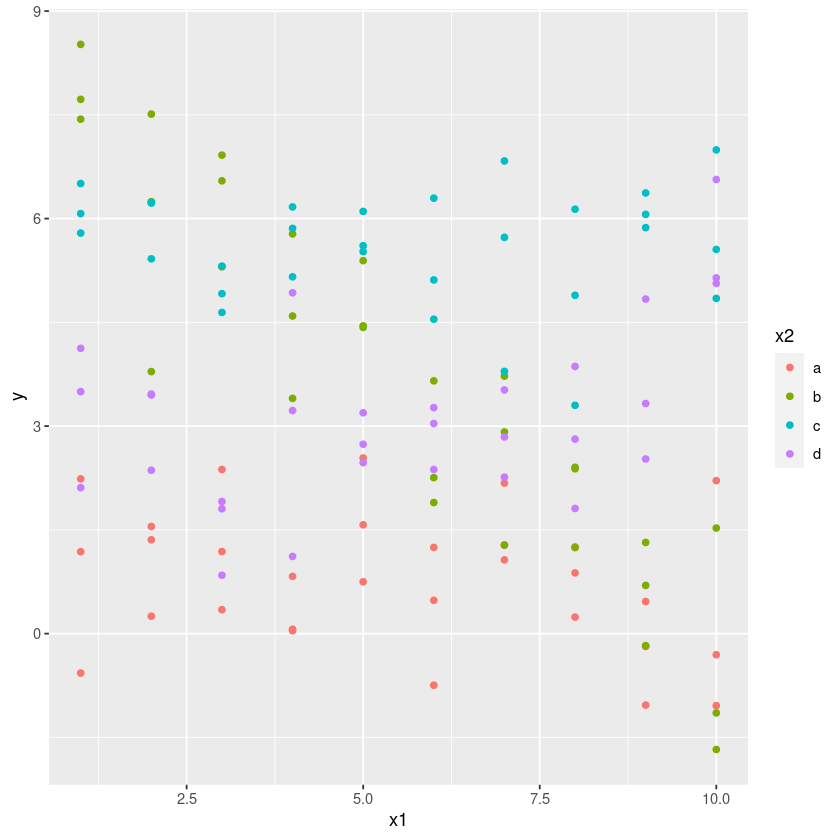

In [66]:
ggplot(sim3, aes(x1, y)) +
    geom_point(aes(color = x2))

There are two possible models you could fit to this data:

In [67]:
mod1 <- lm(y ~ x1 + x2, data = sim3)
mod2 <- lm(y ~ x1 * x2, data = sim3)

When you add variables with `+` , the model will estimate each effect
independent of all the others. It’s possible to fit the so-called interaction by using `*` . For example, `y ~ x1 * x2` is translated to
`y = a_0 + a_1 * a1 + a_2 * a2 + a_12 * a1 * a2` . Note that whenever
you use * , both the interaction and the individual components are
included in the model.

To visualize these models we need two new tricks:

* We have two predictors, so we need to give `data_grid()` both
variables. It finds all the unique values of `x1` and `x2` and then
generates all combinations.

* To generate predictions from both models simultaneously, we
can use `gather_predictions()` , which adds each prediction as
a row. The complement of `gather_predictions()` is
`spread_predictions()` , which adds each prediction to a new
column.

In [68]:
grid <- sim3 %>%
    data_grid(x1, x2) %>%
    gather_predictions(mod1, mod2)

In [69]:
grid

model,x1,x2,pred
<chr>,<int>,<fct>,<dbl>
mod1,1,a,1.674928
mod1,1,b,4.562739
mod1,1,c,6.480664
⋮,⋮,⋮,⋮
mod2,10,b,-0.1624747
mod2,10,c,5.4834219
mod2,10,d,3.9783414


We can visualize the results for both models on one plot using faceting:

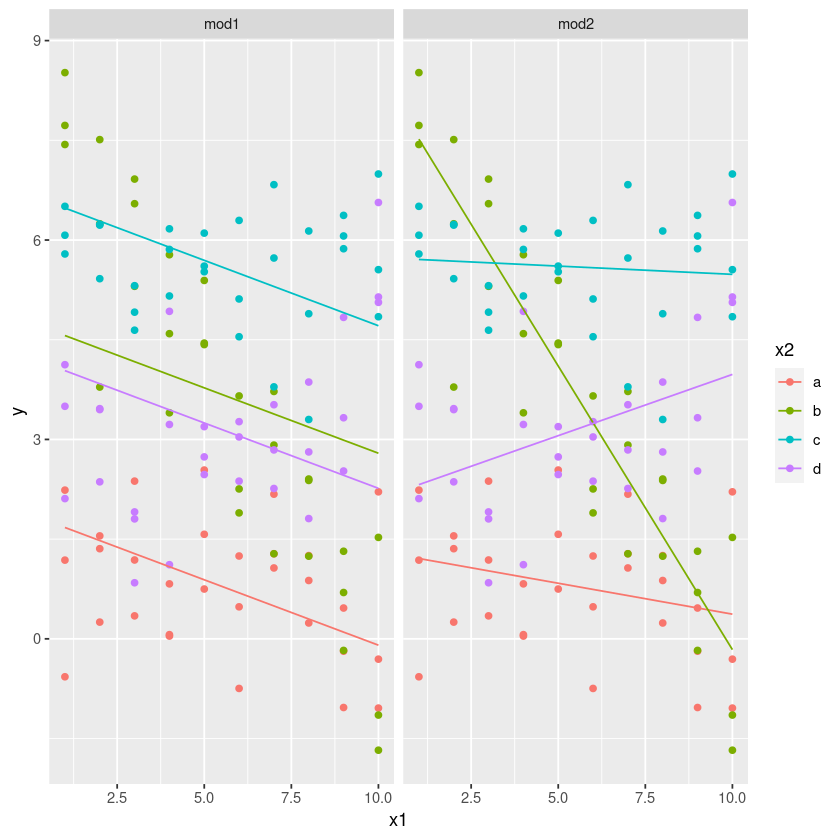

In [70]:
ggplot(sim3, aes(x1, y, color = x2)) +
    geom_point() +
    geom_line(data = grid, aes(y = pred)) +
    facet_wrap(~model)

Note that the model that uses `+` has the same slope for each line, but
different intercepts. The model that uses `*` has a different slope and
intercept for each line.

Which model is better for this data? We can take look at the residuals. Here I’ve faceted by both `model` and `x2` because it makes it easier
to see the pattern within each group:

In [71]:
sim3 <- sim3 %>%
    gather_residuals(mod1, mod2)

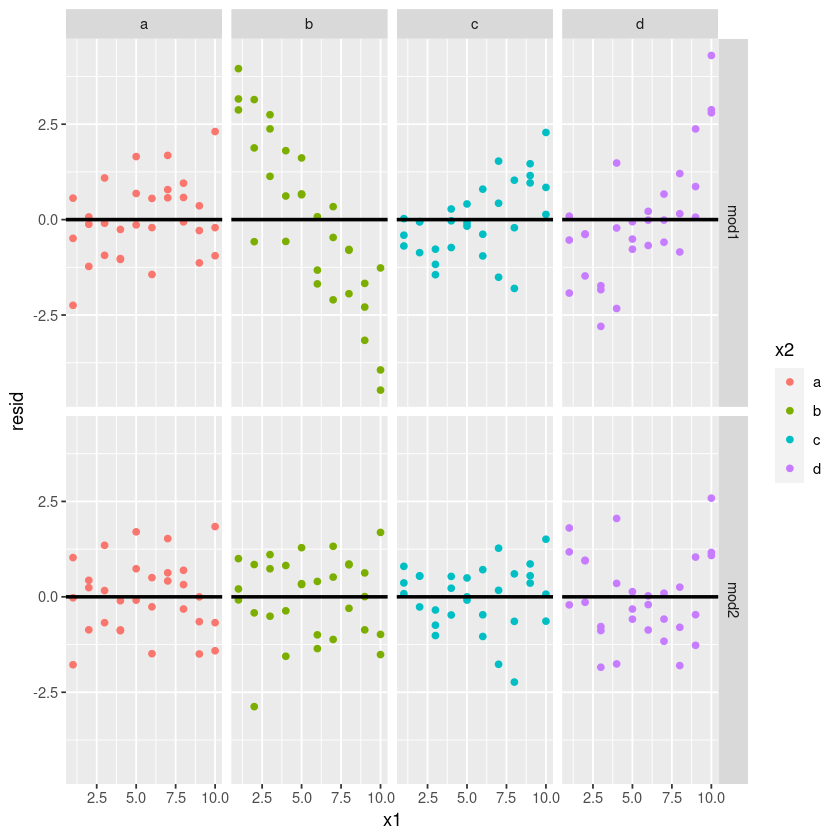

In [72]:
ggplot(sim3, aes(x1, resid, color = x2)) +
    geom_point() +
    geom_ref_line(h = 0,
                  size = 1,
                  colour = 'black') +
    facet_grid(model ~ x2)

There is little obvious pattern in the residuals for `mod2` . The residuals
for mod1 show that the model has clearly missed some pattern in `b` ,
and less so, but still present, is pattern in `c` , and `d` . You might wonder
if there’s a precise way to tell which of `mod1` or `mod2` is better. There
is, but it requires a lot of mathematical background, and we don’t
really care. Here, we’re interested in a qualitative assessment of
whether or not the model has captured the pattern that we’re interested in.

### Interactions (Two Continuous)

Let’s take a look at the equivalent model for two continuous variables. Initially things proceed almost identically to the previous
example:

In [73]:
mod1 <- lm(y ~ x1 + x2, data = sim4)
mod2 <- lm(y ~ x1 * x2, data = sim4)

In [74]:
grid <- sim4 %>%
    data_grid(x1 = seq_range(x1, 5),
              x2 = seq_range(x2, 5)) %>%
    gather_predictions(mod1, mod2)

In [75]:
grid

model,x1,x2,pred
<chr>,<dbl>,<dbl>,<dbl>
mod1,-1,-1.0,0.9963094
mod1,-1,-0.5,-0.3949484
mod1,-1,0.0,-1.7862061
⋮,⋮,⋮,⋮
mod2,1,0.0,1.85712606
mod2,1,0.5,0.94200772
mod2,1,1.0,0.02688937


Note my use of `seq_range()` inside `data_grid()` . Instead of using
every unique value of `x` , I’m going to use a regularly spaced grid of
five values between the minimum and maximum numbers. It’s probably not super important here, but it’s a useful technique in general.
There are three other useful arguments to `seq_range()` :

* `pretty = TRUE` will generate a “pretty” sequence, i.e., something
that looks nice to the human eye. This is useful if you want to
produce tables of output:

In [76]:
seq_range(c(0.0123, 0.923432), n = 5)

[1] 0.012300 0.240083 0.467866 0.695649 0.923432

In [77]:
seq_range(c(0.0123, 0.923432), n = 5, pretty = TRUE)

[1] 0.0 0.2 0.4 0.6 0.8 1.0

* `trim = 0.1` will trim off 10% of the tail values. This is useful if
the variable has a long-tailed distribution and you want to focus
on generating values near the center:

In [78]:
x1 <- rcauchy(100)
seq_range(x1, n = 5)

[1] -14.365222   2.538188  19.441598  36.345008  53.248418

In [79]:
seq_range(x1, n = 5, trim = 0.10)

[1] -5.9492382 -3.0339792 -0.1187201  2.7965389  5.7117980

In [80]:
seq_range(x1, n = 5, trim = 0.25)

[1] -1.5357674 -0.6731416  0.1894842  1.0521100  1.9147358

In [81]:
seq_range(x1, n = 5, trim = 0.5)

[1] -0.7419446 -0.3115891  0.1187663  0.5491218  0.9794773

* `expand = 0.1` is in some sense the opposite of `itrim()` ; itrim() ; it
expands the range by 10%:

In [82]:
x2 <- c(0, 1)
seq_range(x2, n = 25)

[1] 0.00000000 0.04166667 0.08333333 0.12500000 0.16666667 0.20833333
 [7] 0.25000000 0.29166667 0.33333333 0.37500000 0.41666667 0.45833333
[13] 0.50000000 0.54166667 0.58333333 0.62500000 0.66666667 0.70833333
[19] 0.75000000 0.79166667 0.83333333 0.87500000 0.91666667 0.95833333
[25] 1.00000000

In [83]:
seq_range(x2, n = 5, expand = 0.10)

[1] -0.050  0.225  0.500  0.775  1.050

In [84]:
seq_range(x2, n = 5, expand = 0.25)

[1] -0.1250  0.1875  0.5000  0.8125  1.1250

In [85]:
seq_range(x2, n = 5, expand = 0.50)

[1] -0.250  0.125  0.500  0.875  1.250

Next let’s try and visualize that model. We have two continuous pre‐
dictors, so you can imagine the model like a 3D surface. We could
display that using `geom_tile()` :

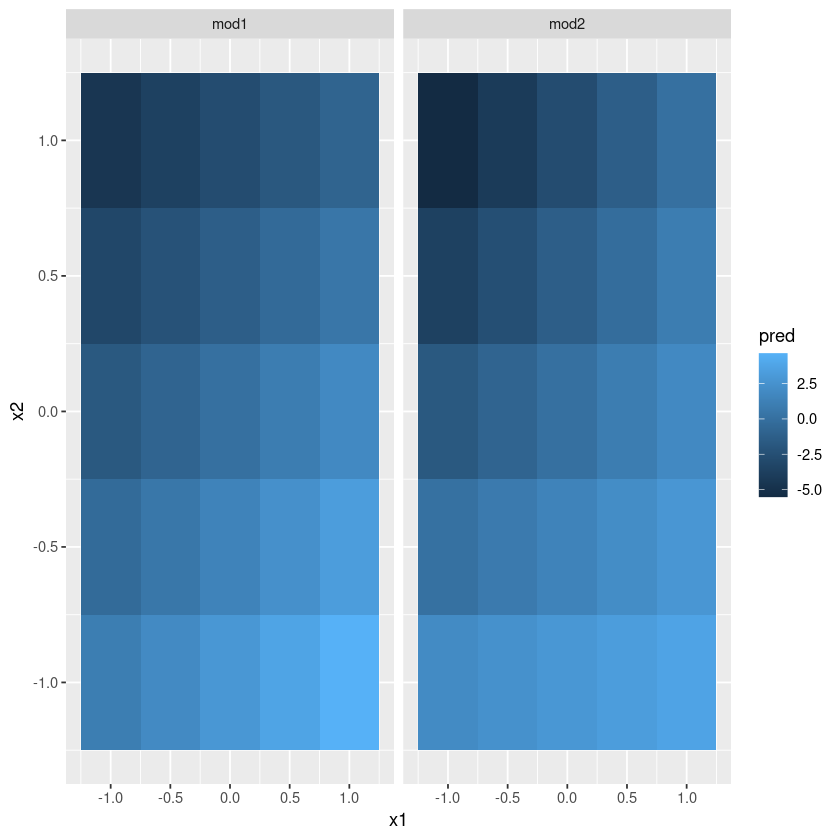

In [86]:
ggplot(grid, aes(x1, x2)) +
    geom_tile(aes(fill = pred)) +
    facet_wrap(~model)

That doesn’t suggest that the models are very different! But that’s
partly an illusion: our eyes and brains are not very good at accurately comparing shades of color. Instead of looking at the surface
from the top, we could look at it from either side, showing multiple
slices:

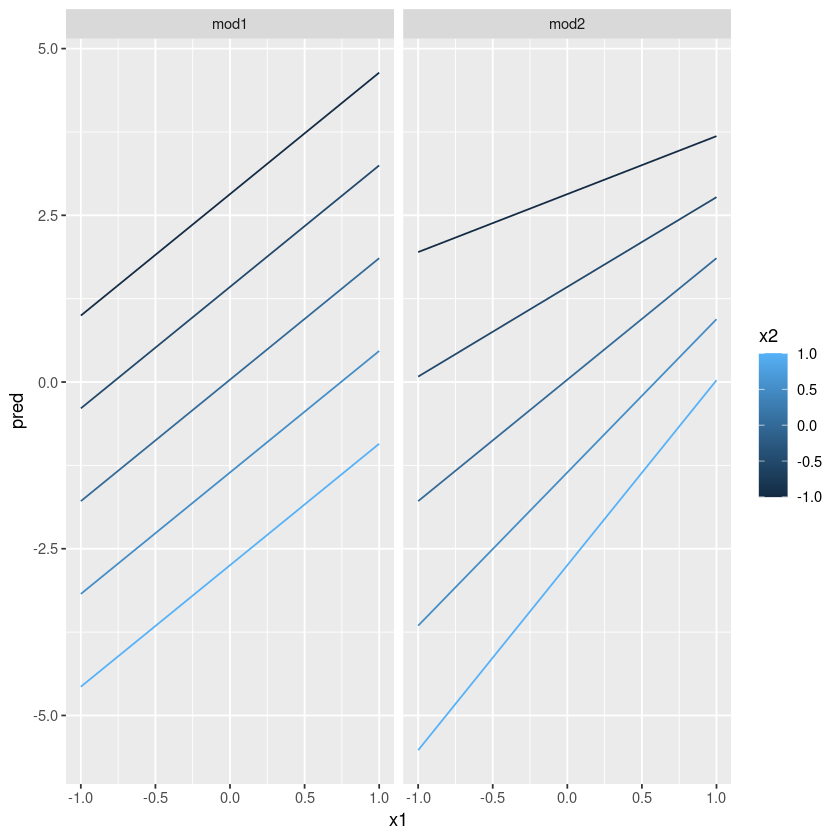

In [87]:
ggplot(grid, aes(x1, pred, color = x2, group = x2)) +
    geom_line() +
    facet_wrap(~model)

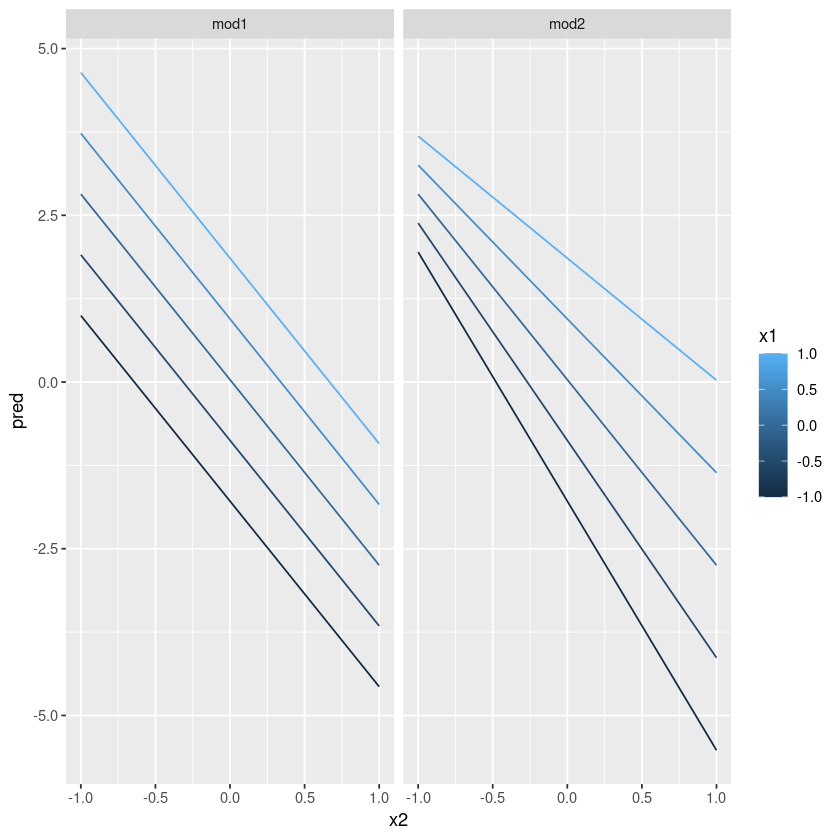

In [88]:
ggplot(grid, aes(x2, pred, color = x1, group = x1)) +
    geom_line() +
    facet_wrap(~model)

This shows you that interaction between two continuous variables
works basically the same way as for a categorical and continuous
variable. An interaction says that there’s not a fixed offset: you need
to consider both values of x1 and x2 simultaneously in order to predict y .

You can see that even with just two continuous variables, coming up
with good visualizations are hard. But that’s reasonable: you
shouldn’t expect it will be easy to understand how three or more
variables simultaneously interact! But again, we’re saved a little
because we’re using models for exploration, and you can gradually
build up your model over time. The model doesn’t have to be perfect, it just has to help you reveal a little more about your data.

### Transformations

You can also perform transformations inside the model formula. For
example, `log(y) ~ sqrt(x1) + x2` is transformed to
`y = a_1 + a_2 * x1 * sqrt(x) + a_3 * x2` . If your transformation involves
`+ , * , ^ ,` or `-` , you’ll need to wrap it in `I()` so R doesn’t treat it like part
of the model specification. For example, `y ~ x + I(x ^ 2)` is translated to
`y = a_1 + a_2 * x + a_3 * x^2` . If you forget the `I()` and
specify `y ~ x ^ 2 + x `, R will compute `y ~ x * x + x` .
`x * x` means the interaction of `x` with itself, which is the same as `x` . R automatically drops redundant variables so `x + x` becomes `x` , meaning
that `y ~ x ^ 2 + x ` specifies the function `y = a_1 + a_2 * x` .
That’s probably not what you intended!

Again, if you get confused about what your model is doing, you can
always use `model_matrix()` to see exactly what equation `lm()` is fitting:

In [89]:
df <- tribble(
    ~y, ~x,
    1, 1,
    2, 2,
    3, 3
)

In [90]:
model_matrix(df, y ~ x ^ 2 + x)

(Intercept),x
<dbl>,<dbl>
1,1
1,2
1,3


In [91]:
model_matrix(df, y ~ I(x ^ 2) + x)

(Intercept),I(x^2),x
<dbl>,<dbl>,<dbl>
1,1,1
1,4,2
1,9,3


Transformations are useful because you can use them to approxi‐
mate nonlinear functions. If you’ve taken a calculus class, you may
have heard of Taylor’s theorem, which says you can approximate any
smooth function with an infinite sum of polynomials. That means
you can use a linear function to get arbitrarily close to a smooth
function by fitting an equation like
`y = a_1 + a_2 * x + a_3 * x^2 + a_4 * x ^ 3` . Typing that sequence by hand is tedious, so R
provides a helper function, `poly()` :

In [92]:
model_matrix(df, y ~ poly(x, 2))

(Intercept),"poly(x, 2)1","poly(x, 2)2"
<dbl>,<dbl>,<dbl>
1,-7.071068e-01,0.4082483
1,-7.850462e-17,-0.8164966
1,7.071068e-01,0.4082483


However there’s one major problem with using `poly()` : outside the
range of the data, polynomials rapidly shoot off to positive or negative infinity. One safer alternative is to use the natural spline,
`splines::ns()` :

In [93]:
library(splines)
model_matrix(df, y ~ ns(x, 2))

(Intercept),"ns(x, 2)1","ns(x, 2)2"
<dbl>,<dbl>,<dbl>
1,0.0000000,0.0000000
1,0.5662628,-0.2108419
1,0.3440969,0.7706021


Let’s see what that looks like when we try and approximate a non-linear function:

In [94]:
sim5 <- tibble(
    x = seq(0, 3.5 * pi, length = 50),
    y = 4 * sin(x) + rnorm(length(x))
)

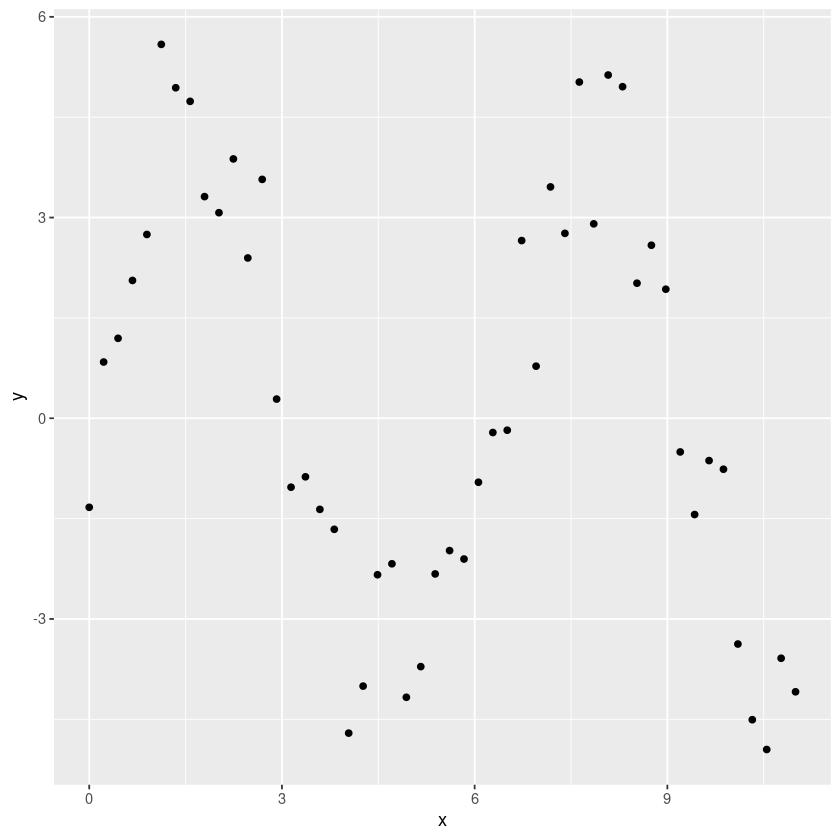

In [95]:
ggplot(sim5, aes(x, y)) +
    geom_point()

I’m going to fit five models to this data:

In [96]:
mod1 <- lm(y ~ ns(x, 1), data = sim5)
mod2 <- lm(y ~ ns(x, 2), data = sim5)
mod3 <- lm(y ~ ns(x, 3), data = sim5)
mod4 <- lm(y ~ ns(x, 4), data = sim5)
mod5 <- lm(y ~ ns(x, 5), data = sim5)

In [97]:
grid <- sim5 %>%
    data_grid(x = seq_range(x, n = 50, expand = 0.1)) %>%
    gather_predictions(mod1, mod2, mod3, mod4, mod5, .pred = 'y')

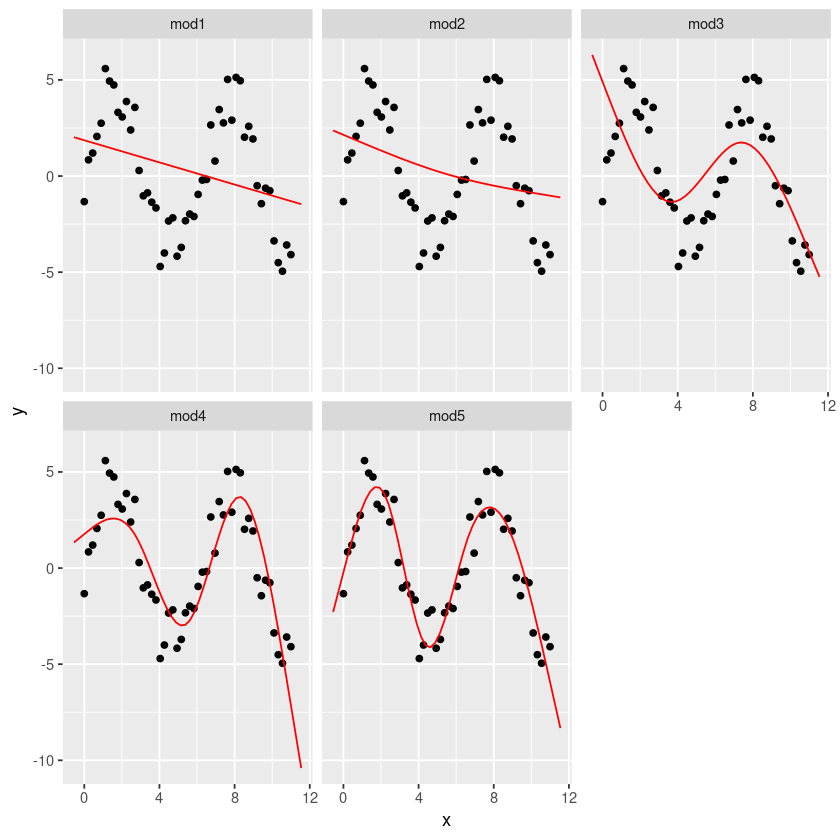

In [98]:
ggplot(sim5, aes(x, y)) +
    geom_point() +
    geom_line(data = grid, color = 'red') +
    facet_wrap(~model)

Notice that the extrapolation outside the range of the data is clearly
bad. This is the downside to approximating a function with a polynomial. But this is a very real problem with every model: the model
can never tell you if the behavior is true when you start extrapolating outside the range of the data that you have seen. You must rely
on theory and science.Notice that the extrapolation outside the range of the data is clearly
bad. This is the downside to approximating a function with a polynomial. But this is a very real problem with every model: the model
can never tell you if the behavior is true when you start extrapolating outside the range of the data that you have seen. You must rely
on theory and science.

### __Excercises__

1. __What happens if you repeat the analysis of `sim2` using a model
without an intercept? What happens to the model equation?
What happens to the predictions?__

To run a model without an intercept, add - 1 or + 0 to the right-hand-side o f the formula:

In [99]:
mod2a <- lm(y ~ x - 1, data = sim2)

In [100]:
mod2 <- lm(y ~ x, data = sim2)

The predictions are exactly the same in the models with and without an intercept:

In [101]:
grid <- sim2 %>%
    data_grid(x) %>%
    spread_predictions(mod2, mod2a)

grid

x,mod2,mod2a
<chr>,<dbl>,<dbl>
a,1.152166,1.152166
b,8.116039,8.116039
c,6.127191,6.127191
d,1.910981,1.910981


2. __Use `model_matrix()` to explore the equations generated for the
models I fit to `sim3` and `sim4` . Why is * a good shorthand for
interaction?__

For x1 * x2 when x2 is a categorical variable produces indicator variables x2b, x2c, x2d and variables x1:x2b, x1:x2c, and x1:x2d which are the products of x1 and x2* variables:

In [102]:
x3 <- model_matrix(y ~ x1 * x2, data = sim3)
x3

(Intercept),x1,x2b,x2c,x2d,x1:x2b,x1:x2c,x1:x2d
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,10,0,0,1,0,0,10
1,10,0,0,1,0,0,10
1,10,0,0,1,0,0,10


We can confirm that the variables x1:x2b is the product of x1 and x2b,

In [103]:
all(x3[["x1:x2b"]] == (x3[["x1"]] * x3[["x2b"]]))

[1] TRUE

and similarly for x1:x2c and x2c, and x1:x2d and x2d:

In [104]:
all(x3[["x1:x2c"]] == (x3[["x1"]] * x3[["x2c"]]))

[1] TRUE

In [105]:
all(x3[["x1:x2d"]] == (x3[["x1"]] * x3[["x2d"]]))

[1] TRUE

For x1 * x2 where both x1 and x2 are continuous variables, model_matrix() creates variables x1, x2, and x1:x2:



In [106]:
x4 <- model_matrix(y ~ x1 * x2, data = sim4)
x4

(Intercept),x1,x2,x1:x2
<dbl>,<dbl>,<dbl>,<dbl>
1,-1,-1,1
1,-1,-1,1
1,-1,-1,1
⋮,⋮,⋮,⋮
1,1,1,1
1,1,1,1
1,1,1,1


Confirm that x1:x2 is the product of the x1 and x2,

In [107]:
all(x4[["x1"]] * x4[["x2"]] == x4[["x1:x2"]])

[1] TRUE

3. __Using the basic principles, convert the formulas in the following two models into functions. (Hint: start by converting the categorical variable into 0-1 variables.)__

In [108]:
mod1 <- lm(y ~ x1 + x2, data = sim3)
mod2 <- lm(y ~ x1 * x2, data = sim3)

The problem is to convert the formulas in the models into functions. I will assume that the function is only handling the conversion of the right hand side of the formula into a model matrix. The functions will take one argument, a data frame with `x1` and `x2` columns, and it will return a data frame. In other words, the functions will be special cases of the `model_matrix()` function.

Consider the right hand side of the first formula, `~ x1 + x2`. In the sim3 data frame, the column `x1` is an integer, and the variable `x2` is a factor with four levels.

In [109]:
levels(sim3$x2)

[1] "a" "b" "c" "d"



Since x1 is numeric it is unchanged. Since x2 is a factor it is replaced with columns of indicator variables for all but one of its levels. I will first consider the special case in which x2 only takes the levels of x2 in sim3. In this case, “a” is considered the reference level and omitted, and new columns are made for “b”, “c”, and “d”.



In [110]:
model_matrix_mod1 <- function(.data) {
  mutate(.data,
    x2b = as.numeric(x2 == "b"),
    x2c = as.numeric(x2 == "c"),
    x2d = as.numeric(x2 == "d"),
    `(Intercept)` = 1
  ) %>%
    select(`(Intercept)`, x1, x2b, x2c, x2d)
}

In [111]:
model_matrix_mod1(sim3)

(Intercept),x1,x2b,x2c,x2d
<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,1,0,0,0
1,1,0,0,0
1,1,0,0,0
⋮,⋮,⋮,⋮,⋮
1,10,0,0,1
1,10,0,0,1
1,10,0,0,1


A more general function for `~ x1 + x2` would not hard-code the specific levels in `x2`.

In [112]:
model_matrix_mod1b <- function(.data) {
  # the levels of x2
  lvls <- levels(.data$x2)
  # drop the first level
  # this assumes that there are at least two levels
  lvls <- lvls[2:length(lvls)]
  # create an indicator variable for each level of x2
  for (lvl in lvls) {
    # new column name x2 + level name
    varname <- str_c("x2", lvl)
    # add indicator variable for lvl
    .data[[varname]] <- as.numeric(.data$x2 == lvl)
  }
  # generate the list of variables to keep
  x2_variables <- str_c("x2", lvls)
  # Add an intercept
  .data[["(Intercept)"]] <- 1
  # keep x1 and x2 indicator variables
  select(.data, `(Intercept)`, x1, all_of(x2_variables))
}

In [113]:
model_matrix_mod1b(sim3)

(Intercept),x1,x2b,x2c,x2d
<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,1,0,0,0
1,1,0,0,0
1,1,0,0,0
⋮,⋮,⋮,⋮,⋮
1,10,0,0,1
1,10,0,0,1
1,10,0,0,1


Consider the right hand side of the first formula, ~ x1 * x2. The output data frame will consist of x1, columns with indicator variables for each level (except the reference level) of x2, and columns with the x2 indicator variables multiplied by x1.

As with the previous formula, first I’ll write a function that hard-codes the levels of x2.

In [114]:
model_matrix_mod2 <- function(.data) {
  mutate(.data,
    `(Intercept)` = 1,
    x2b = as.numeric(x2 == "b"),
    x2c = as.numeric(x2 == "c"),
    x2d = as.numeric(x2 == "d"),
    `x1:x2b` = x1 * x2b,
    `x1:x2c` = x1 * x2c,
    `x1:x2d` = x1 * x2d
  ) %>%
    select(`(Intercept)`, x1, x2b, x2c, x2d, `x1:x2b`, `x1:x2c`, `x1:x2d`)
}

In [115]:
model_matrix_mod2(sim3)

(Intercept),x1,x2b,x2c,x2d,x1:x2b,x1:x2c,x1:x2d
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,10,0,0,1,0,0,10
1,10,0,0,1,0,0,10
1,10,0,0,1,0,0,10


For a more general function which will handle arbitrary levels in x2, I will extend the model_matrix_mod1b() function that I wrote earlier.



In [116]:
model_matrix_mod2b <- function(.data) {
  # get dataset with x1 and x2 indicator variables
  out <- model_matrix_mod1b(.data)
  # get names of the x2 indicator columns
  x2cols <- str_subset(colnames(out), "^x2")
  # create interactions between x1 and the x2 indicator columns
  for (varname in x2cols) {
    # name of the interaction variable
    newvar <- str_c("x1:", varname)
    out[[newvar]] <- out$x1 * out[[varname]]
  }
  out
}

In [117]:
model_matrix_mod2b(sim3)

(Intercept),x1,x2b,x2c,x2d,x1:x2b,x1:x2c,x1:x2d
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,10,0,0,1,0,0,10
1,10,0,0,1,0,0,10
1,10,0,0,1,0,0,10


These functions could be further generalized to allow for x1 and x2 to be either numeric or factors. However, generalizing much more than that and we will soon start reimplementing all of the matrix_model() function.

4. __For sim4 , which of mod1 and mod2 is better? I think mod2 does a
slightly better job at removing patterns, but it’s pretty subtle.
Can you come up with a plot to support my claim?__

Estimate models mod1 and mod2 on sim4,

In [118]:
mod1 <- lm(y ~ x1 + x2, data = sim4)
mod2 <- lm(y ~ x1 * x2, data = sim4)

and add the residuals from these models to the sim4 data

In [119]:
sim4_mods <- gather_residuals(sim4, mod1, mod2)

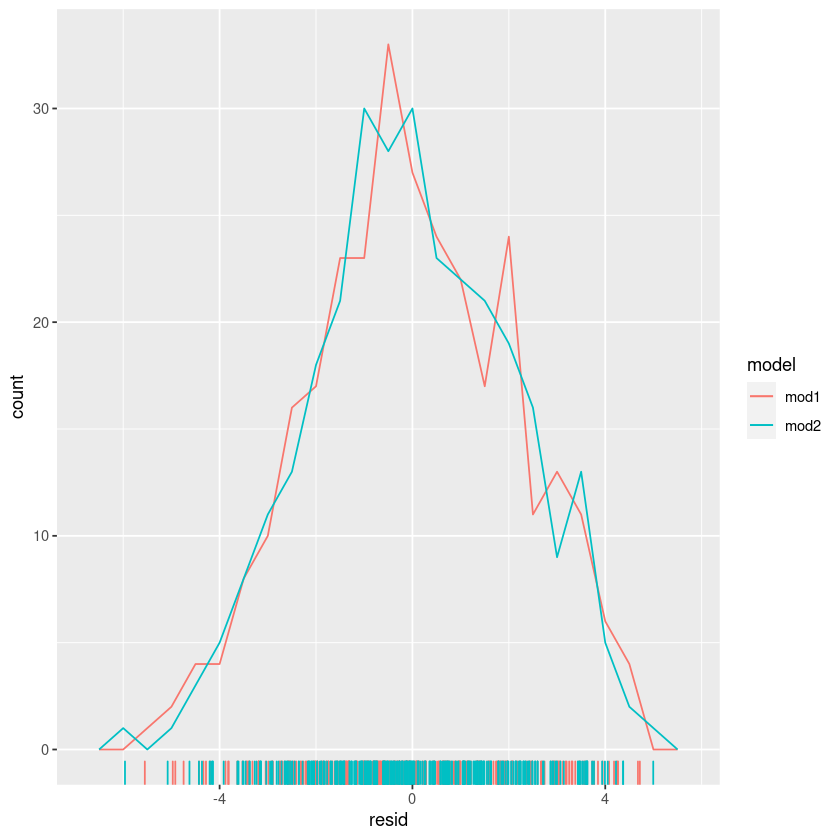

In [120]:

ggplot(sim4_mods, aes(x = resid, colour = model)) +
  geom_freqpoly(binwidth = 0.5) +
  geom_rug()

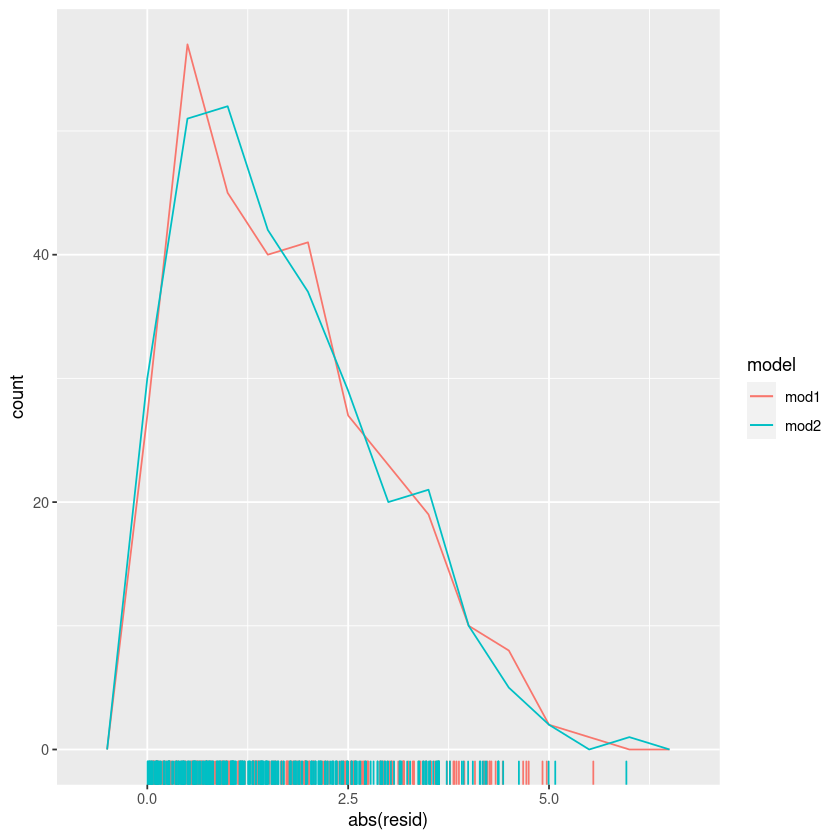

In [121]:
ggplot(sim4_mods, aes(x = abs(resid), colour = model)) +
  geom_freqpoly(binwidth = 0.5) +
  geom_rug()

does not show much difference in the residuals between the models. However, mod2 appears to have fewer residuals in the tails of the distribution between 2.5 and 5 (although the most extreme residuals are from mod2.

This is confirmed by checking the standard deviation of the residuals of these models,

In [122]:
sim4_mods %>%
  group_by(model) %>%
  summarise(resid = sd(resid))

model,resid
<chr>,<dbl>
mod1,2.103281
mod2,2.067068


The standard deviation of the residuals of `mod2` is smaller than that of `mod1`.

## __Missing Values__

Missing values obviously cannot convey any information about the
relationship between the variables, so modeling functions will drop
any rows that contain missing values. R’s default behavior is to
silently drop them, but `options(na.action = na.warn)` (run in the
prerequisites), makes sure you get a warning:

In [123]:
df <- tribble(
    ~x, ~y,
    1, 2.2,
    2, NA,
    3, 3.5,
    4, 8.3,
    NA, 10
)

In [124]:
mod <- lm(y ~ x, data = df)

Warning message:
“Dropping 2 rows with missing values”


To suppress the warning, set `na.action = na.exclude` :

In [125]:
mod <- lm(y ~ x, data = df, na.action = na.exclude)

You can always see exactly how many observations were used with
`nobs()` :

In [126]:
nobs(mod)

[1] 3

## __Other Model Families__

This chapter has focused exclusively on the class of linear models,
which assume a relationship of the form
`y = a_1 * x1 + a_2 * x2 + ... + a_n * xn` .
Linear models additionally assume that the
residuals have a normal distribution, which we haven’t talked about.
There is a large set of model classes that extend the linear model in
various interesting ways. Some of them are:

* Generalized linear models, e.g., `stats::glm()` . Linear models
assume that the response is continuous and the error has a nor‐
mal distribution. Generalized linear models extend linear mod‐
els to include noncontinuous responses (e.g., binary data or
counts). They work by defining a distance metric based on the
statistical idea of likelihood.
* Generalized additive models, e.g., `mgcv::gam()` , extend generalized linear models to incorporate arbitrary smooth functions.
That means you can write a formula like `y ~ s(x)` , which
becomes an equation like `y = f(x)` , and let `gam()` estimate what
that function is (subject to some smoothness constraints to
make the problem tractable).
* Penalized linear models, e.g., `glmnet::glmnet()` , add a penalty
term to the distance that penalizes complex models (as defined
by the distance between the parameter vector and the origin).
This tends to make models that generalize better to new datasets
from the same population.
* Robust linear models, e.g., `MASS:rlm()` , tweak the distance to
downweight points that are very far away. This makes them less
sensitive to the presence of outliers, at the cost of being not
quite as good when there are no outliers.
* Trees, e.g., `rpart::rpart()` , attack the problem in a completely
different way than linear models. They fit a piece-wise constant
model, splitting the data into progressively smaller and smaller
pieces. Trees aren’t terribly effective by themselves, but they are
very powerful when used in aggregate by models like random
forests (e.g., `randomForest::randomForest()` ) or gradient boosting machines (e.g., `xgboost::xgboost` .)

These models all work similarly from a programming perspective.
Once you’ve mastered linear models, you should find it easy to mas‐
ter the mechanics of these other model classes. Being a skilled mod‐
eler is a mixture of some good general principles and having a big
toolbox of techniques. Now that you’ve learned some general tools
and one useful class of models, you can go on and learn more classes
from other sources.